# SHEET 02
### Task 01: Over-sampling for Generating Synthetic Data
The goal of this task is to write a piece of code that can generate synthetic samples by using an over-sampling technique. To this end, your piece of code should implement a statistical method that takes as an input (i) a real dataset, (ii) an amount of samples to be synthetically generated, and (ii) the number of nearest neighbors k to be considered. The second parameter, i.e., the amount of samples to be synthetically generated, should be a percentage value indicating the fraction of synthetic samples with respect to the number of real samples. For example, if you give 100% as a second parameter, your piece of code should generate as many synthetic samples as the number of samples in the real dataset. Next, your piece of code should operate as follows:
- a) First, you should normalize the input dataset. To this end, your source code should support at least two different methods for data normalization. The user should be able to select from the command line which of them to use.
- b) For each real sample, you should identify its k nearest neighbors using the Manhattan distance. The algorithm of identifying the k nearest neighbors and the computation of the the Manhattan distance should be implemented by you, i.e., you are not allowed to use any preexisting function from a library.
- c) For each real sample, you should randomly select one of each k nearest neighbors and compute the difference between the sample under consideration and the selected neighbor. This difference then should be multiplied by a random number between 0 and 1. The result of the multiplication should be added to the sample under consideration. The result of the latter addition is the new synthetic sample. The operations in this item should be repeated until you generate the predefined number of synthetic samples for a given real dataset.
- d) The operations above should be paralyzed as much as possible to ensure an optimal per- formance of the algorithm. Finally, using the algorithm described above and the one-day dataset used to train your GAN in the previous practical sheet, you should generate two different synthetic datasets for k = 2 and k = 5. Each of these datasets should have length of one day. Beside the source code, the generated datasets should be also uploaded in Moodle.

In [1]:
# Cleaning Data (hai-22.04/train_4.csv)

# Import necessary libraries
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/hai-security-dataset/hai-22.04/train4.csv')

# Check if there are any missing values and handle them if necessary
if df.isnull().sum().any():
    df = df.fillna(df.mean())  # Alternatively, handle missing values as required

# Convert the 'timestamp' column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Define the start and end times for a 24-hour period from the first timestamp
start_time = df['timestamp'].iloc[0]
end_time = start_time + pd.Timedelta(days=1)

# Filter the dataset for this 24-hour range
train_data_one_day = df[(df['timestamp'] >= start_time) & (df['timestamp'] < end_time)]

# Select the features and exclude the 'Attack' column for normalization
features = train_data_one_day.drop(columns=['Attack','timestamp'])

features.to_csv('/kaggle/working/train_4_task_02.csv', index=False)

In [2]:
test = pd.read_csv('/kaggle/working/train_4_task_02.csv')
test.shape

(86400, 86)

In [3]:
# Source code to generate synthetic data using oversampling method
%%writefile task_01_cpu.py
import sys
import numpy as np
import pandas as pd
import argparse
from joblib import Parallel, delayed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from loguru import logger

# Configure Loguru to log only INFO level messages to stdout
logger.remove()
logger.add(sys.stdout, level="INFO", filter=lambda record: record["level"].name == "INFO")

def load_dataset(filepath):
    """
    Load a dataset from a CSV file.

    :param filepath: str, path to the CSV file
    :return: pandas.DataFrame, the loaded dataset
    """
    logger.info(f"Loading dataset from: {filepath}")
    return pd.read_csv(filepath)

def normalize_data(dataset, method='min_max'):
    """
    Normalize the dataset using either min-max or z-score normalization.

    :param dataset: pandas.DataFrame, the dataset to be normalized
    :param method: str, the normalization method ('min_max' or 'z_score')
    :return: numpy.ndarray, the normalized dataset, sklearn.preprocessing.Scaler, the scaler used for normalization
    """
    logger.info(f"Normalizing data using '{method}' method")
    scaler = MinMaxScaler() if method == 'min_max' else StandardScaler()
    normalized_data = scaler.fit_transform(dataset)
    return normalized_data, scaler

def get_decimal_precision(series):
    """Determine decimal precision for a pandas Series."""
    precisions = series.astype(str).apply(lambda x: len(x.split('.')[-1]) if '.' in x else 0)
    return precisions.max()

def inverse_normalize(normalized_data, scaler, original_data):
    """
    Inverse transform the normalized data to its original scale and preserve column names.

    :param normalized_data: numpy.ndarray, the normalized dataset
    :param scaler: sklearn.preprocessing.Scaler, the scaler used for normalization
    :param original_columns: list, the original column names of the dataset
    :return: pandas.DataFrame, the inverse-transformed dataset
    """
    logger.info("Inverse transforming the normalized data to the original scale")
    inverse_transformed = scaler.inverse_transform(normalized_data)
    synthetic_df = pd.DataFrame(inverse_transformed, columns=original_data.columns)
    
    # Apply original data's decimal precision to synthetic data
    for col in original_data.columns:
        precision = get_decimal_precision(original_data[col])
        synthetic_df[col] = synthetic_df[col].round(precision)
    
    return synthetic_df

def manhattan_distance(a, b):
    """
    Compute the Manhattan distance between two arrays.

    :param a: numpy.ndarray, single data point
    :param b: numpy.ndarray, dataset to compute distance from
    :return: numpy.ndarray, distances between a and all points in b
    """
    return np.sum(np.abs(a - b), axis=1)

def find_k_nearest_neighbors(sample, dataset, k):
    """
    Find k nearest neighbors using Manhattan distance (L1 norm).

    :param sample: numpy.ndarray, single data point
    :param dataset: numpy.ndarray, dataset to search for neighbors
    :param k: int, number of nearest neighbors to find
    :return: numpy.ndarray, k nearest neighbors
    """
    distances = manhattan_distance(sample, dataset)
    nearest_indices = np.argsort(distances)[:k]
    return dataset[nearest_indices]

def generate_synthetic_sample(sample, neighbors):
    """
    Generate a synthetic sample by selecting a random neighbor and applying a random perturbation.

    :param sample: numpy.ndarray, original sample
    :param neighbors: numpy.ndarray, k nearest neighbors
    :return: numpy.ndarray, synthetic sample generated by interpolation between sample and a random neighbor
    """
    random_neighbor = neighbors[np.random.randint(0, len(neighbors))]
    diff = random_neighbor - sample
    return sample + np.random.random(sample.shape) * diff

def oversample_data(dataset, sampling_strategy, k):
    """
    Apply custom oversampling to generate synthetic samples.

    :param dataset: numpy.ndarray, dataset to oversample
    :param sampling_strategy: float, percentage of samples to generate relative to the dataset size
    :param k: int, number of nearest neighbors to consider for synthetic sample generation
    :return: numpy.ndarray, oversampled dataset including original and synthetic samples
    """
    logger.info(f"Oversampling data with {sampling_strategy*100:.2f}% synthetic samples")
    num_samples_to_generate = int(len(dataset) * sampling_strategy)

    def create_synthetic_sample(i):
        sample = dataset[i]
        neighbors = find_k_nearest_neighbors(sample, dataset, k)
        return generate_synthetic_sample(sample, neighbors)

    logger.info("Generating synthetic samples in parallel")
    synthetic_samples = Parallel(n_jobs=-1)(delayed(create_synthetic_sample)(i) for i in range(num_samples_to_generate))
    # return np.vstack([dataset, *synthetic_samples])
    return np.array(synthetic_samples)


def save_synthetic_data(dataset, filename="synthetic_data.csv"):
    """
    Save the synthetic data to a CSV file.
    
    :param dataset: numpy array, the data to save
    :param filename: str, output filename
    """
    pd.DataFrame(dataset).to_csv(filename, index=False)
    print(f"Synthetic data saved to {filename}")

def main(args):
    dataset = load_dataset(args.dataset)
    normalized_data, scaler = normalize_data(dataset, args.normalization)
    sampling_strategy = args.percentage / 100
    synthetic_data = oversample_data(normalized_data.astype(np.float32), sampling_strategy, args.k)
    synthetic_data_original_scale = inverse_normalize(synthetic_data, scaler, dataset)
    save_synthetic_data(synthetic_data_original_scale, filename=args.output)

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Synthetic Data Generation with Custom Oversampling")

    parser.add_argument("--dataset", required=True, type=str, help="Path to real dataset (CSV)")
    parser.add_argument("--percentage", required=True, type=float, help="Percentage of samples to generate")
    parser.add_argument("--k", required=True, type=int, choices=[2, 5], help="Number of nearest neighbors")
    parser.add_argument("--normalization", required=True, choices=['min_max', 'z_score'], help="Normalization method")
    parser.add_argument("--output", type=str, default="synthetic_data.csv", help="Output file")

    args = parser.parse_args()
    main(args)


Writing task_01_cpu.py


In [35]:
!python task_01_cpu.py \
    --dataset "/kaggle/working/train_4_task_02.csv" \
    --percentage 100 \
    --k 2 \
    --normalization "z_score" \
    --output "k2_synthetic_data.csv"

2024-11-14 08:38:56.867 | INFO     | __main__:load_dataset:20 - Loading dataset from: /kaggle/working/train_4_task_02.csv
2024-11-14 08:38:57.888 | INFO     | __main__:normalize_data:31 - Normalizing data using 'z_score' method
2024-11-14 08:38:58.025 | INFO     | __main__:oversample_data:105 - Oversampling data with 100.00% synthetic samples
2024-11-14 08:38:58.025 | INFO     | __main__:oversample_data:113 - Generating synthetic samples in parallel
2024-11-14 08:54:49.722 | INFO     | __main__:inverse_normalize:50 - Inverse transforming the normalized data to the original scale
Synthetic data saved to k2_synthetic_data.csv


# Verifying Synthetic Data

In [33]:
# Validation synthetic data
synth_data = pd.read_csv('/kaggle/working/k5_synthetic_data.csv')
synth_data.head()
synth_data.shape

(86400, 86)

In [34]:
# Validation original data with synthetic data information
orig_data = pd.read_csv('/kaggle/working/train_4_task_02.csv')
orig_data.head()
orig_data.shape

(86400, 86)

Distance metrics for each feature: {'P1_B2004': 2.9743055555557044e-06, 'P1_B2016': 6.77241898148152e-05, 'P1_B3004': 0.00153952499999982, 'P1_B3005': 0.0014993570601852671, 'P1_B4002': 4.041400462961686e-05, 'P1_B4005': 0.0024004872685184746, 'P1_B400B': 0.5178372469907413, 'P1_B4022': 0.00040005740740740745, 'P1_FCV01D': 0.00820878576388893, 'P1_FCV01Z': 0.011934173032407408, 'P1_FCV02D': 0.020245322453703744, 'P1_FCV02Z': 0.005780452893518473, 'P1_FCV03D': 0.001153956134259249, 'P1_FCV03Z': 0.0014930582175926067, 'P1_FT01': 0.02363295578703685, 'P1_FT01Z': 0.12114404826388812, 'P1_FT02': 0.39495036504628667, 'P1_FT02Z': 0.5519503376157335, 'P1_FT03': 0.024126077546296358, 'P1_FT03Z': 0.04909704745370279, 'P1_LCV01D': 0.0016298293981481628, 'P1_LCV01Z': 0.0014054988425926127, 'P1_LIT01': 0.009884753240741043, 'P1_PCV01D': 0.0019920625000000003, 'P1_PCV01Z': 0.002173553356481508, 'P1_PCV02D': 0.0, 'P1_PCV02Z': 9.57996527777887e-05, 'P1_PIT01': 0.00010244895833332495, 'P1_PIT01_HH': 0.

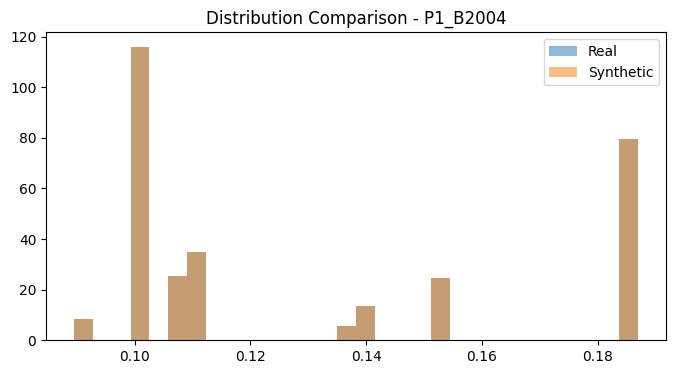

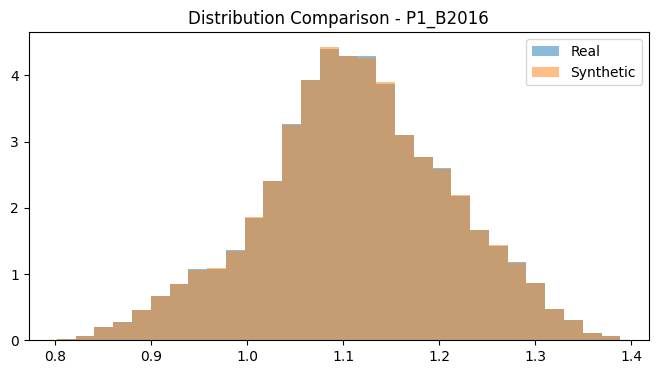

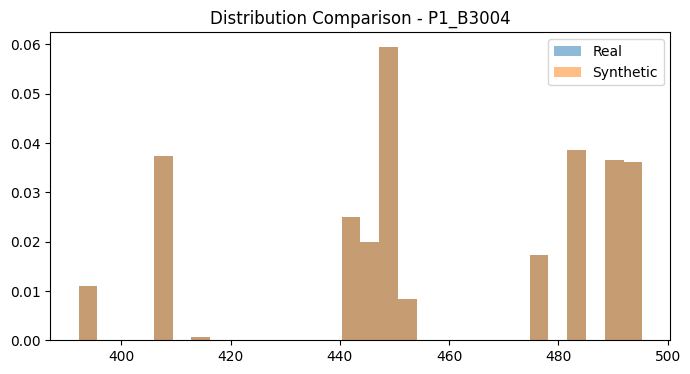

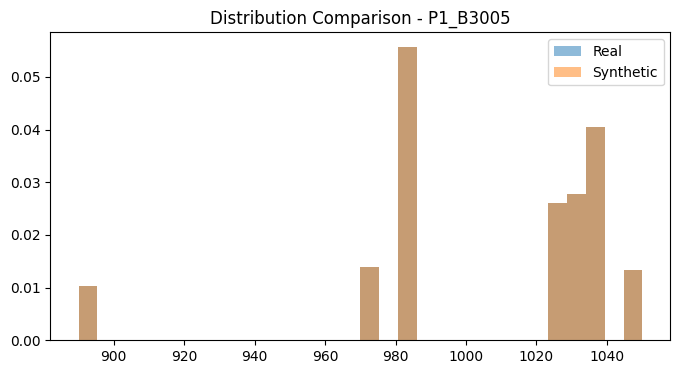

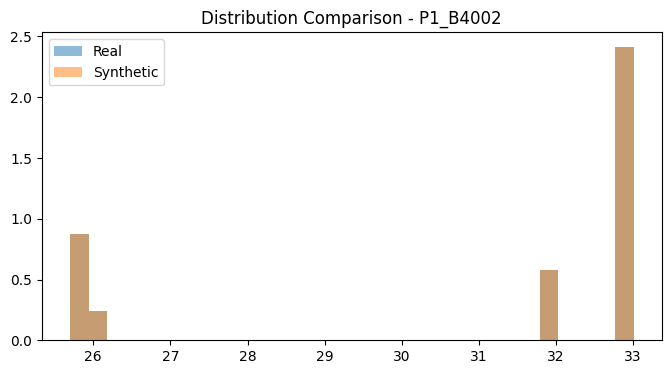

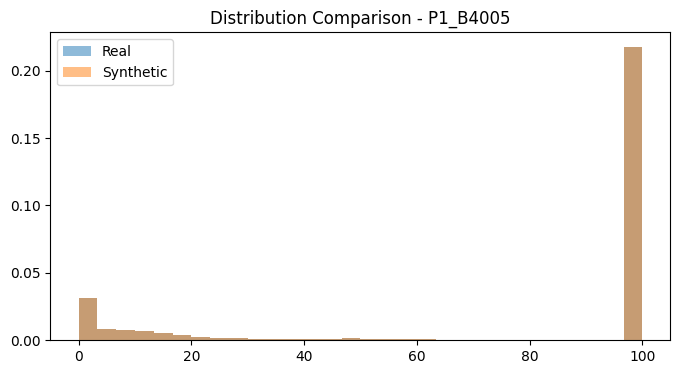

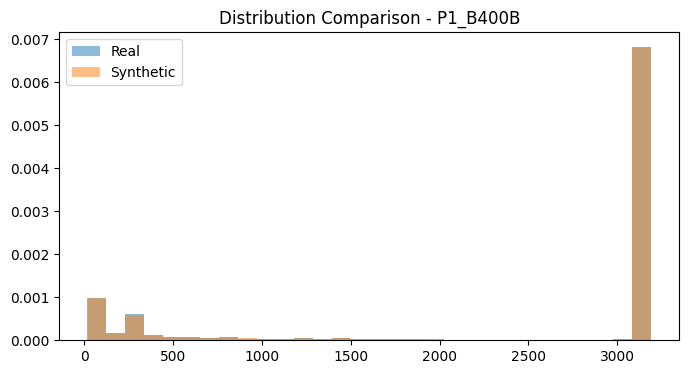

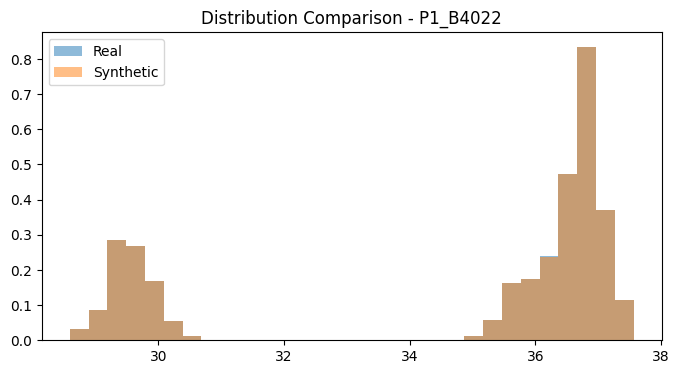

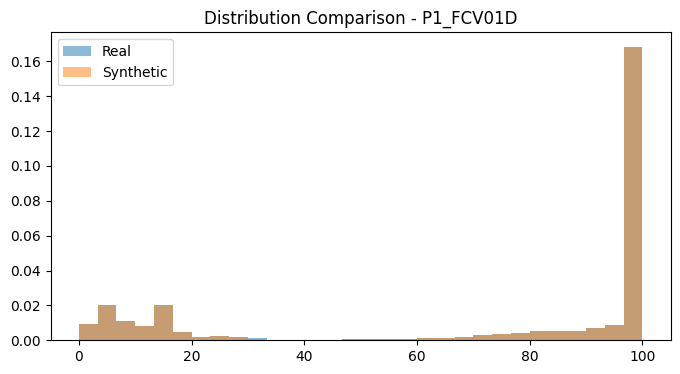

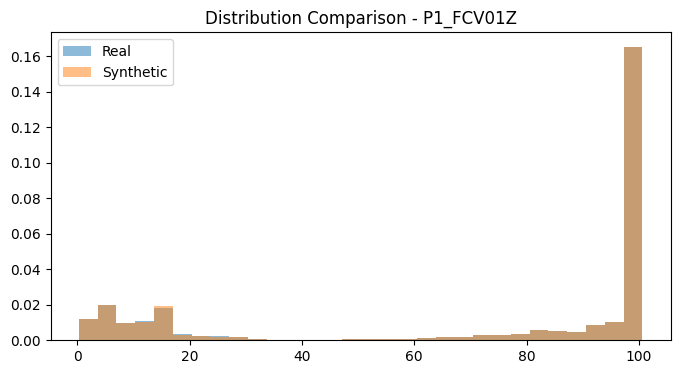

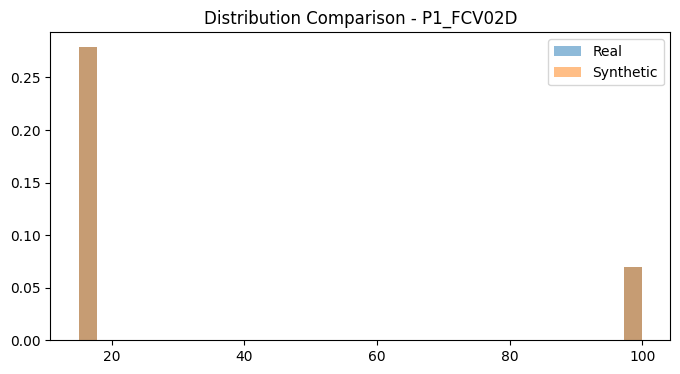

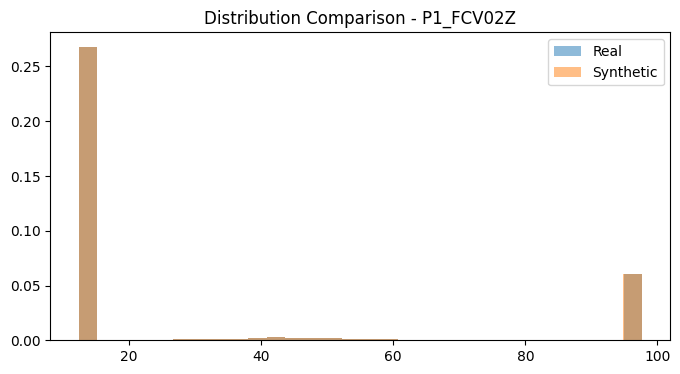

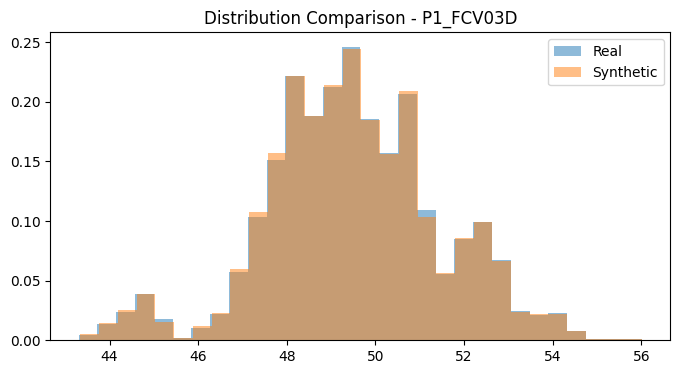

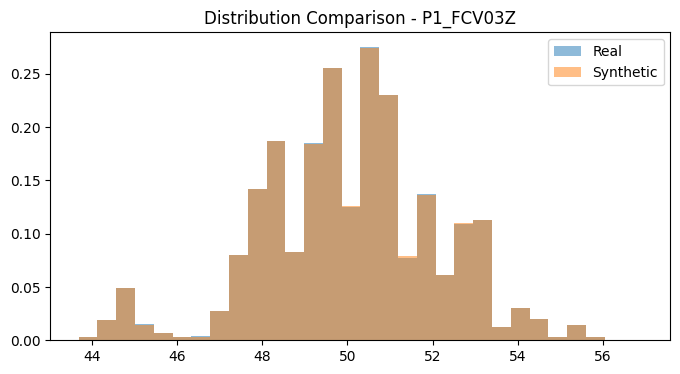

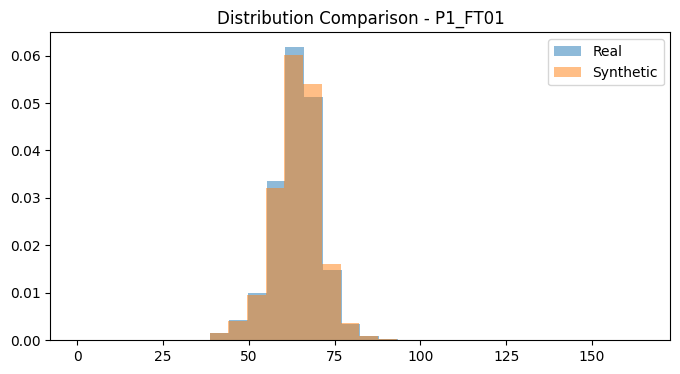

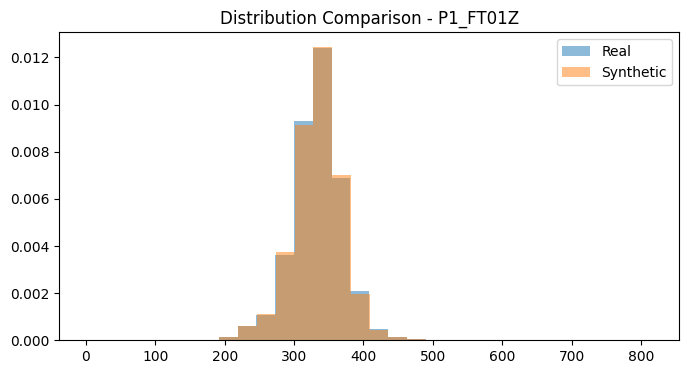

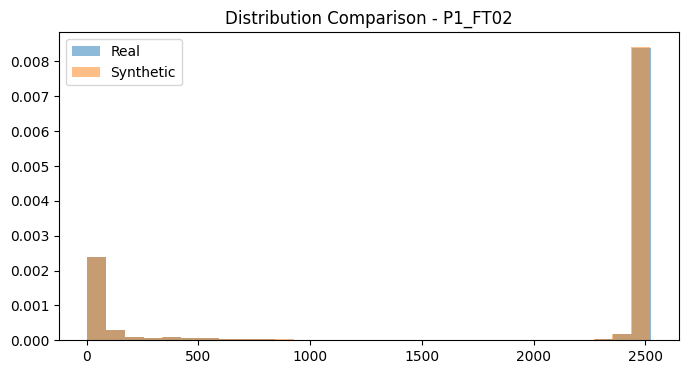

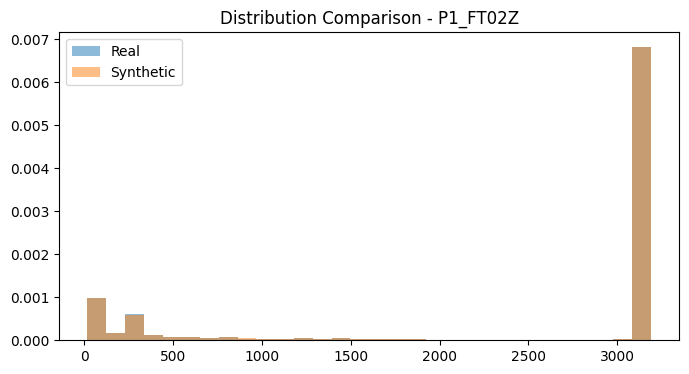

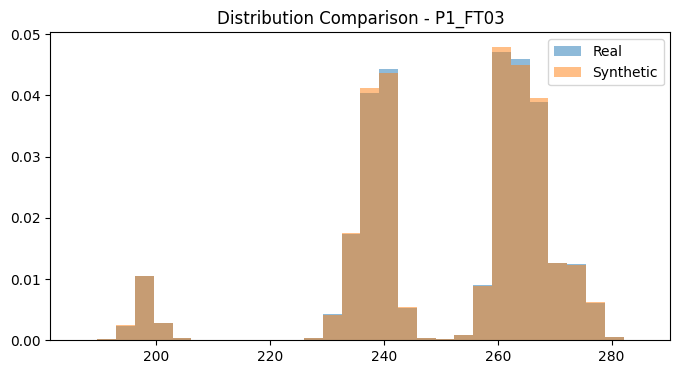

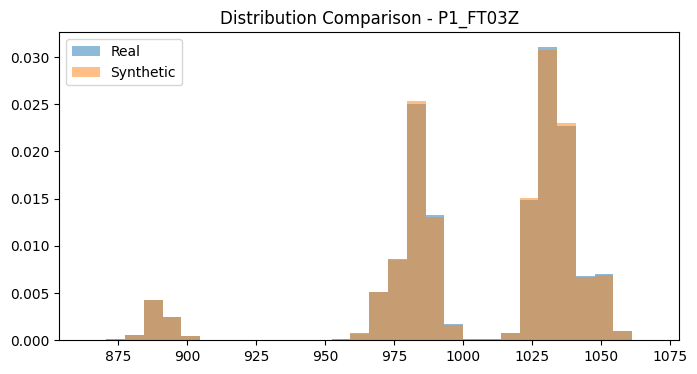

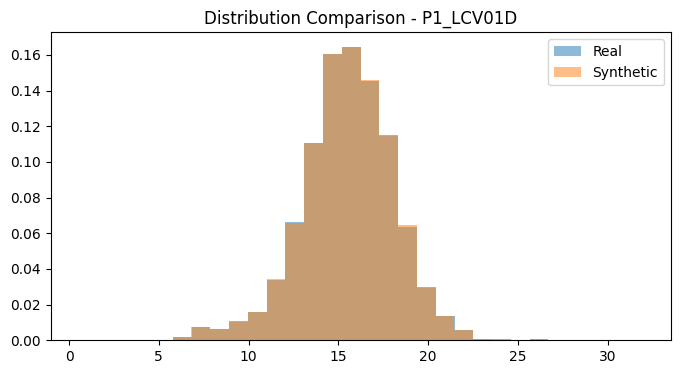

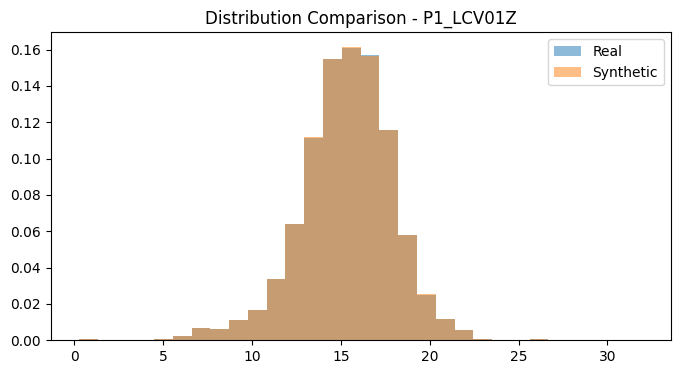

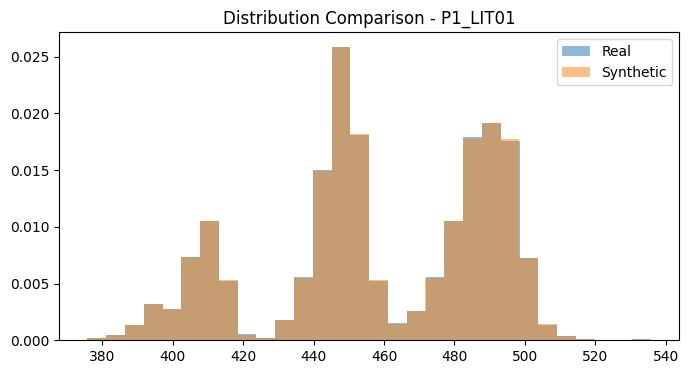

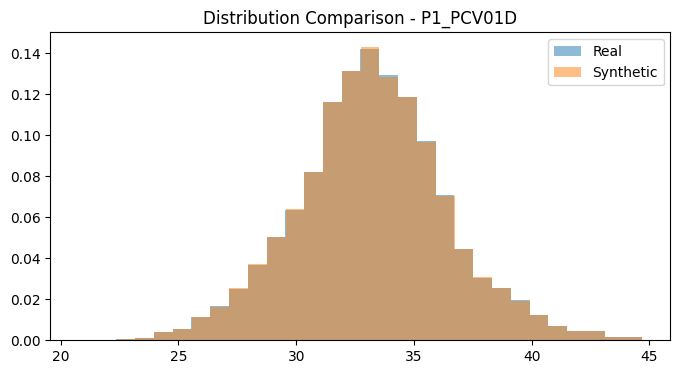

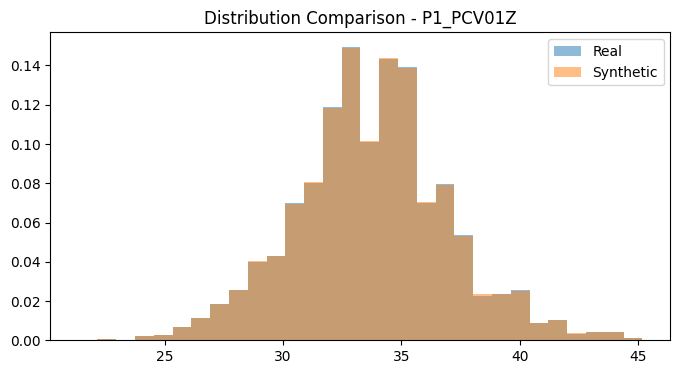

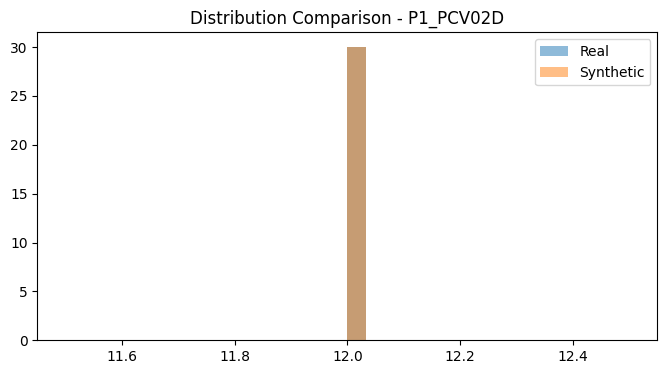

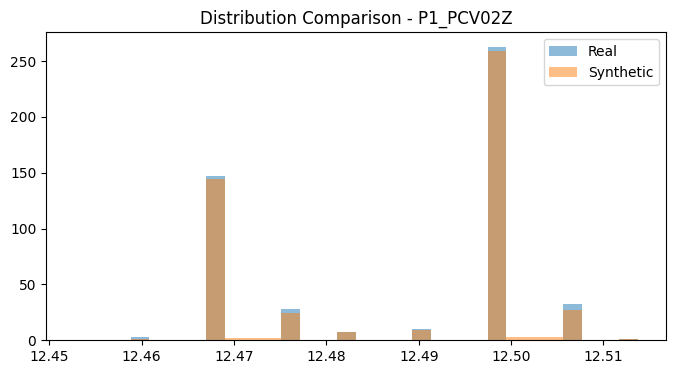

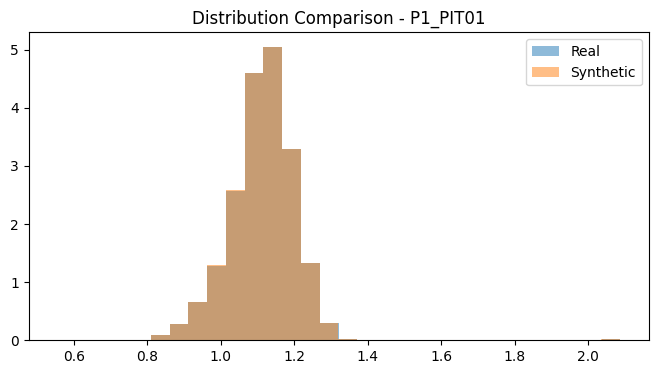

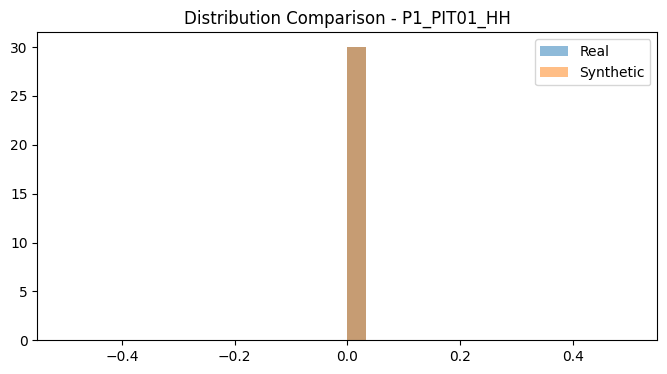

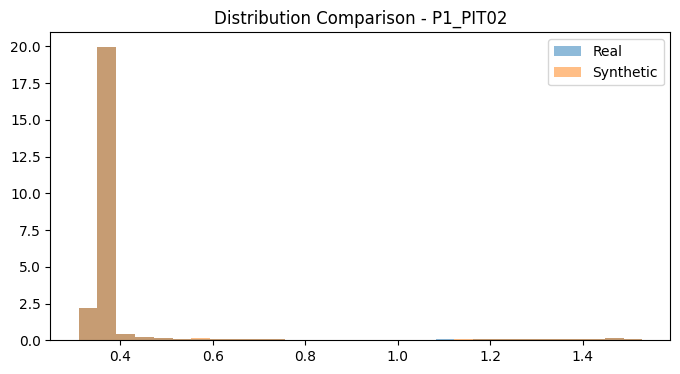

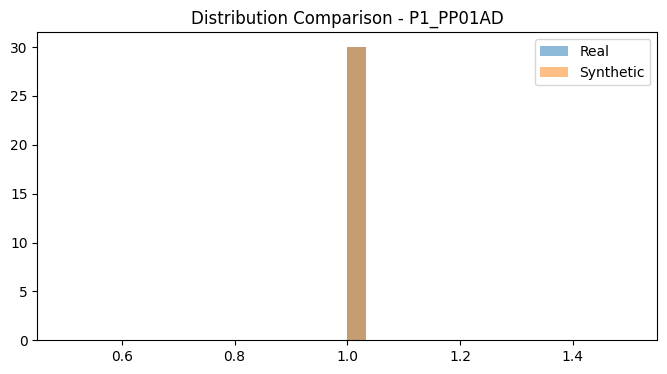

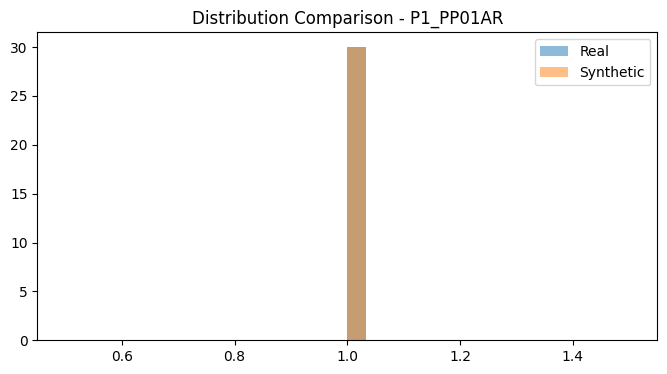

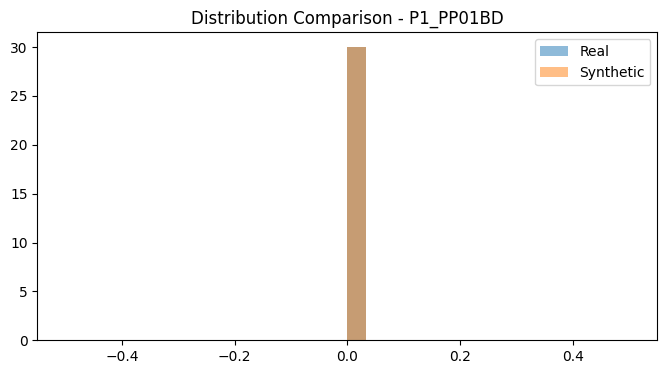

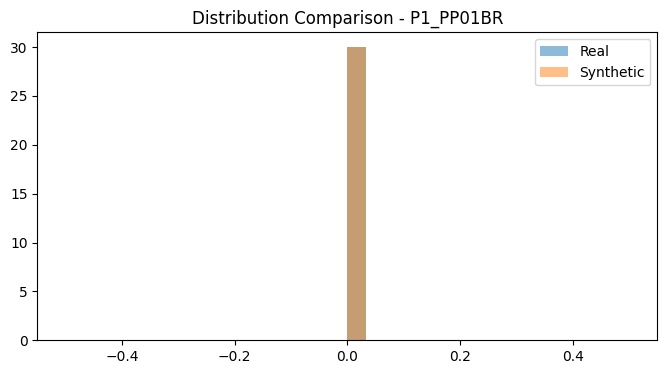

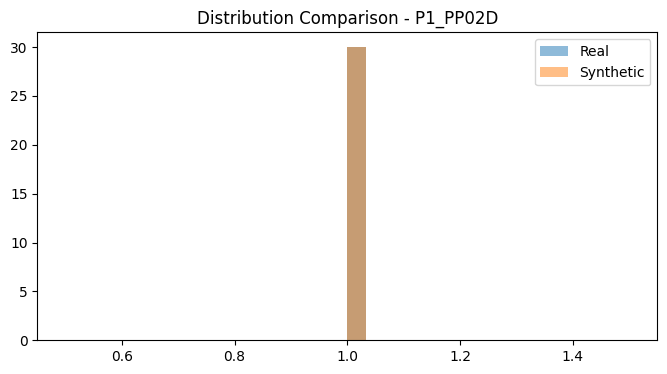

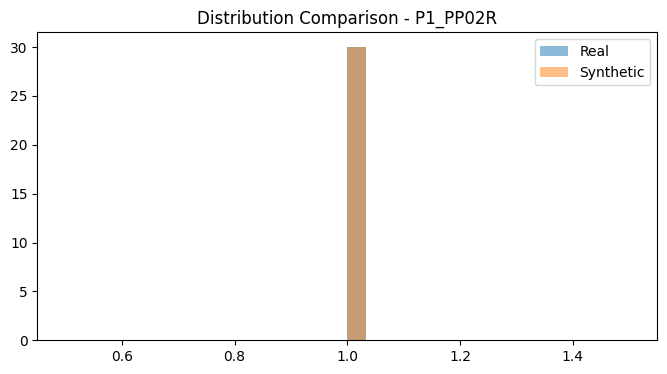

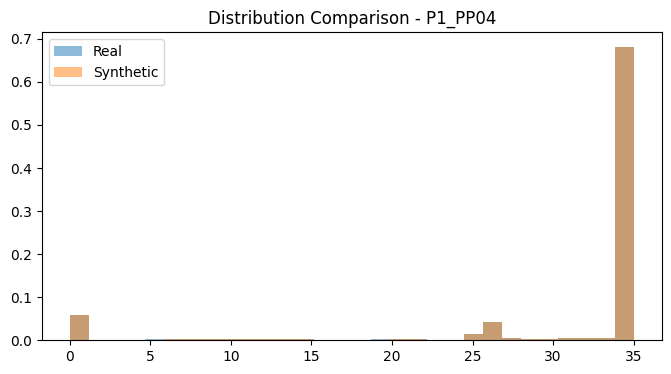

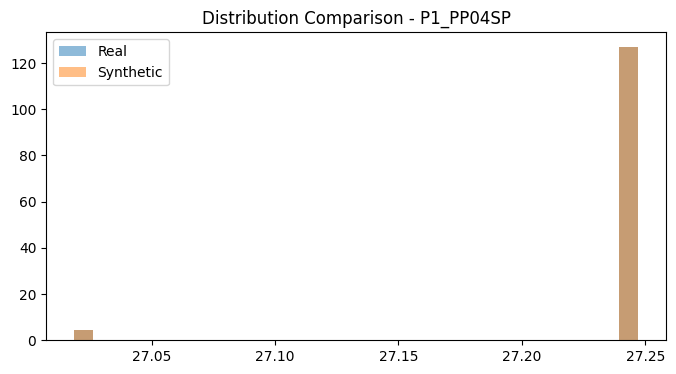

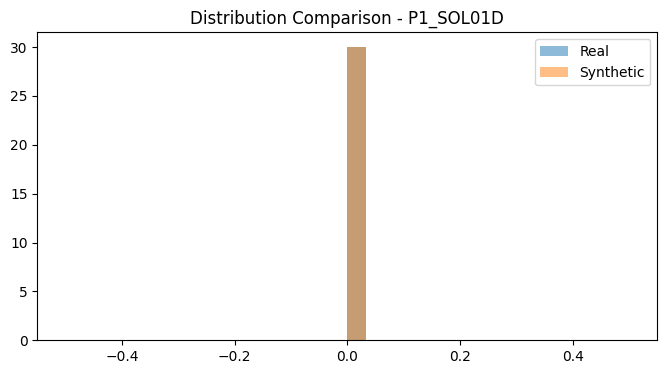

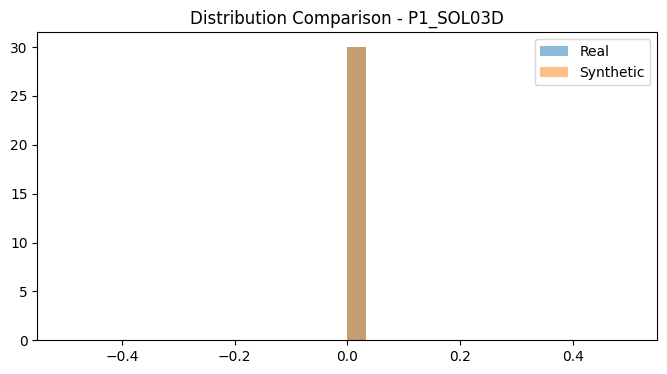

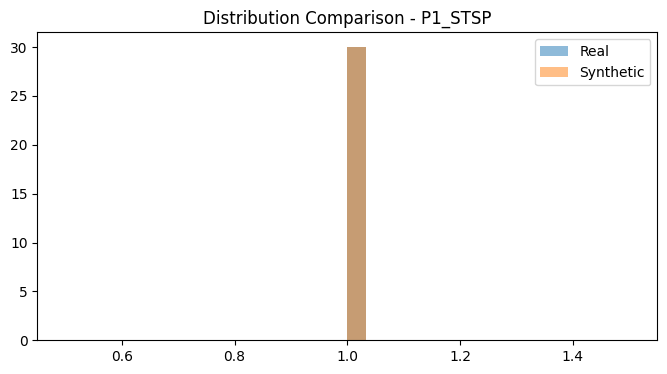

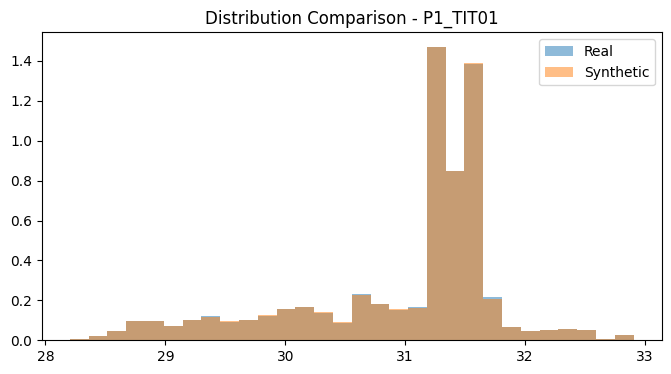

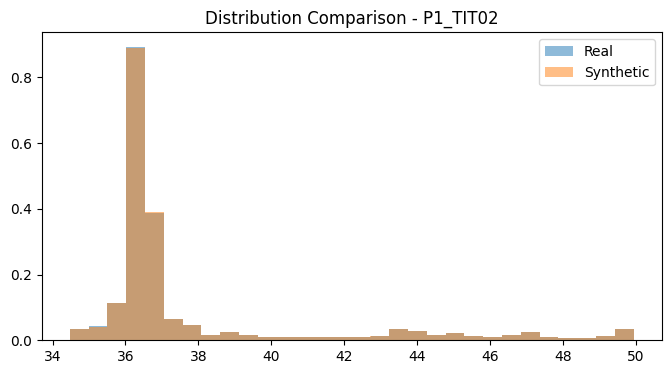

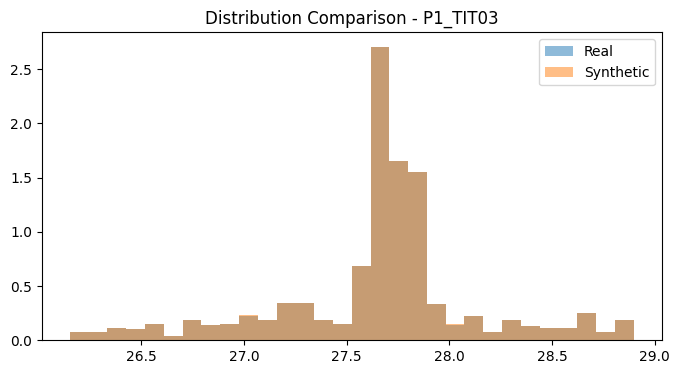

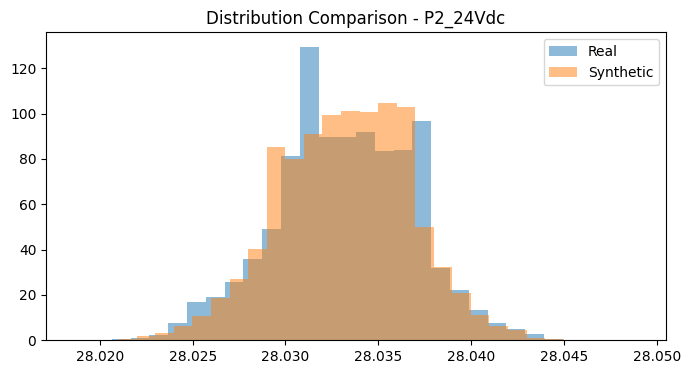

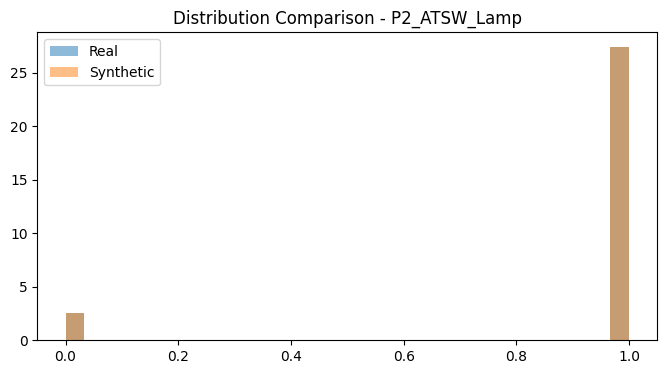

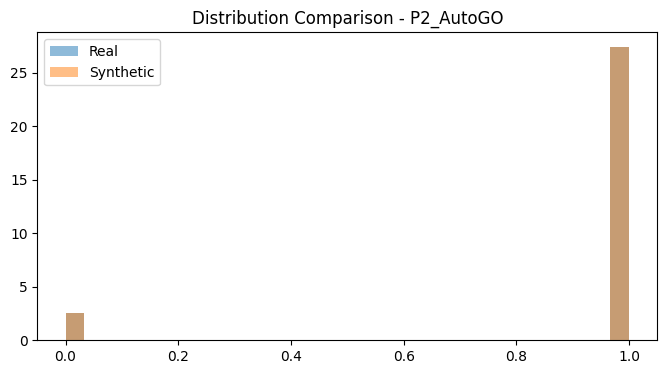

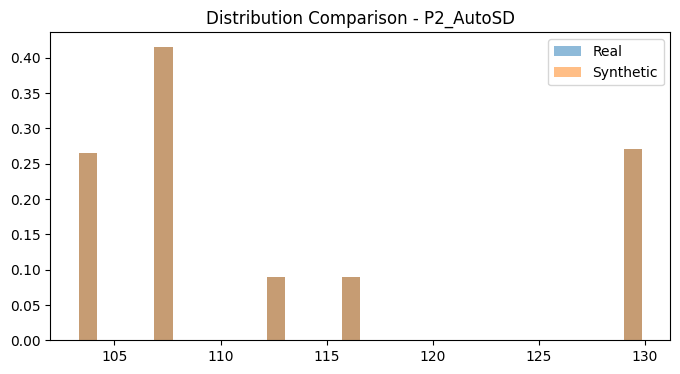

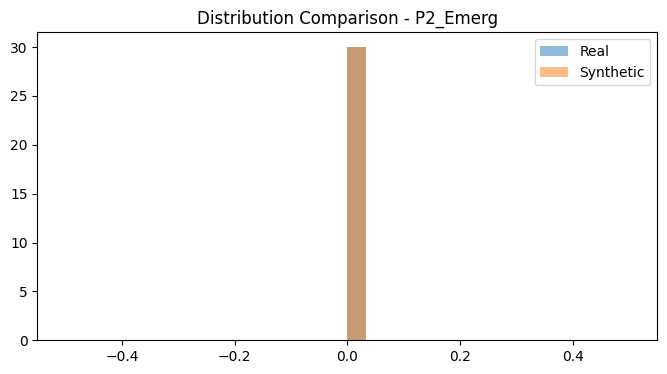

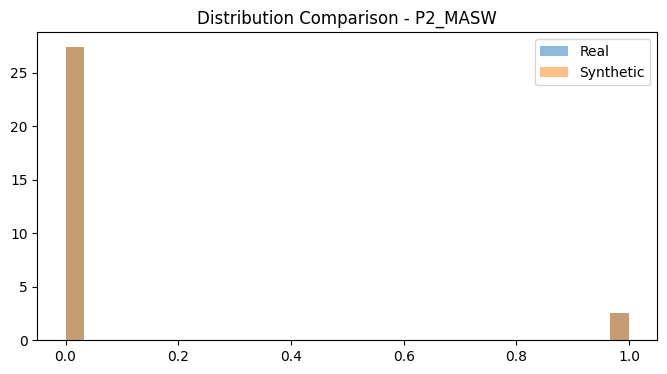

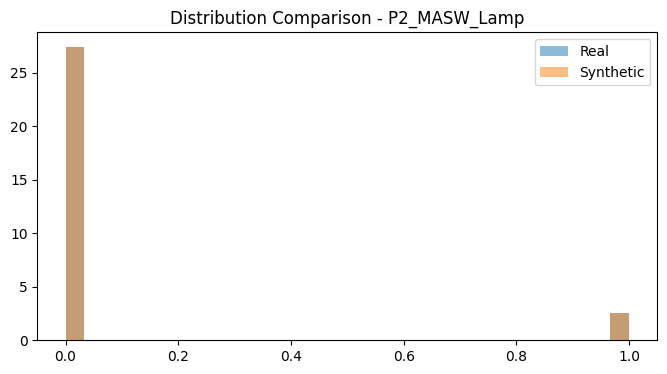

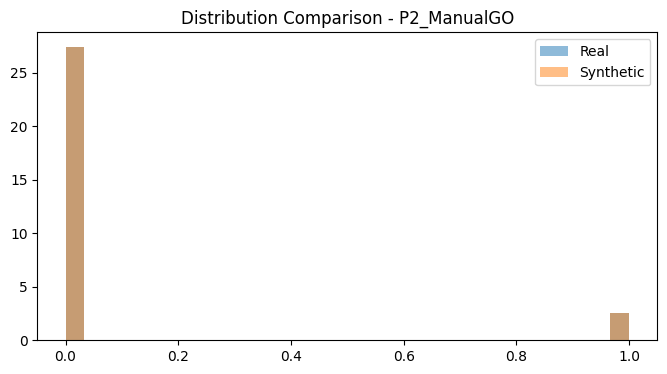

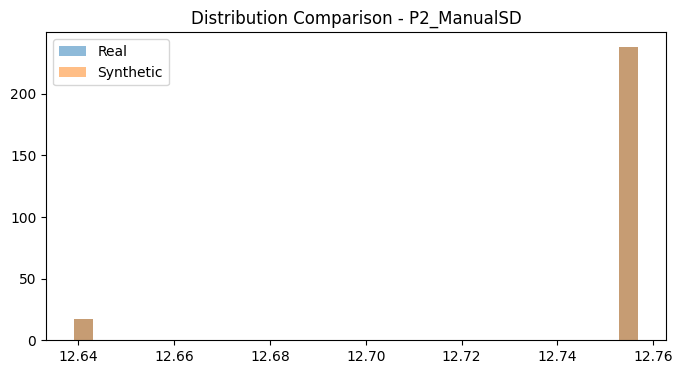

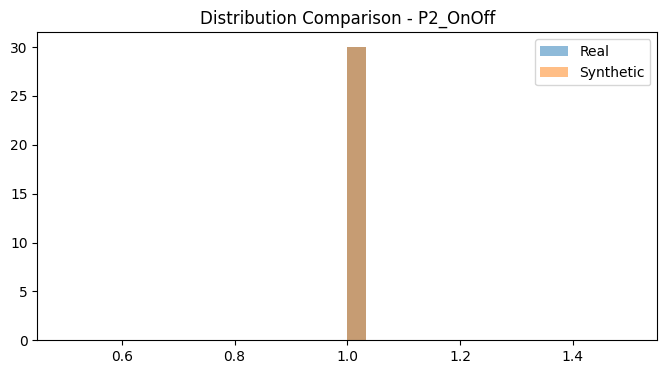

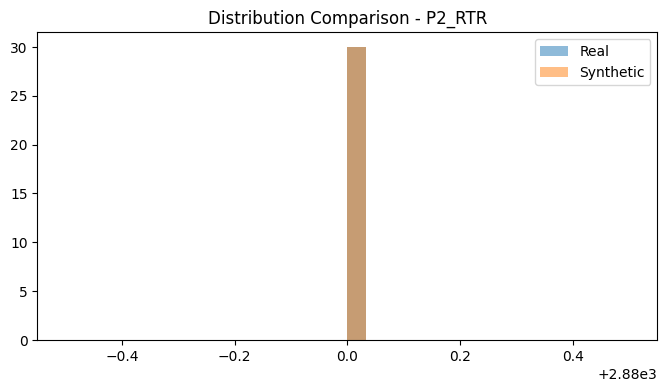

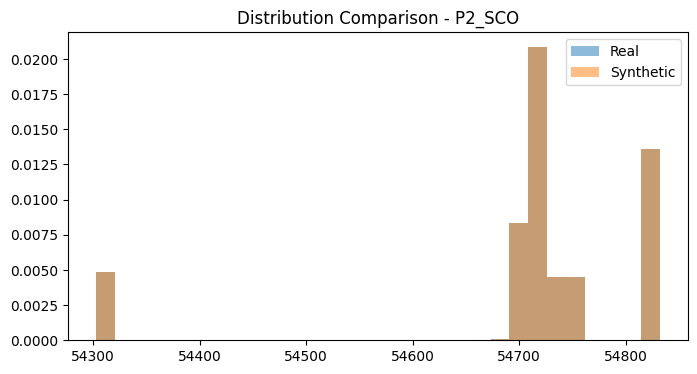

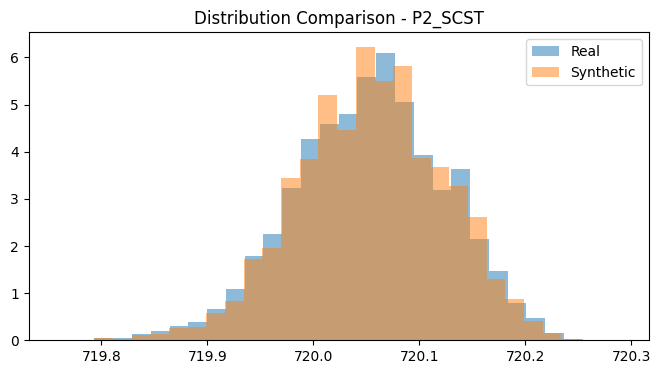

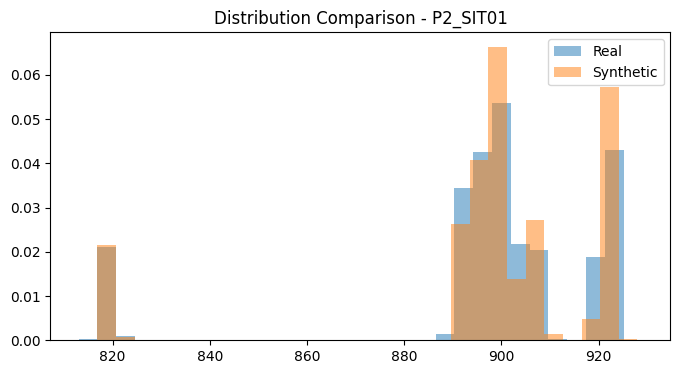

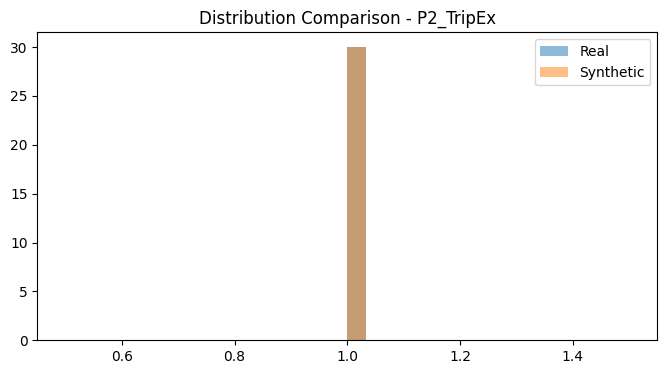

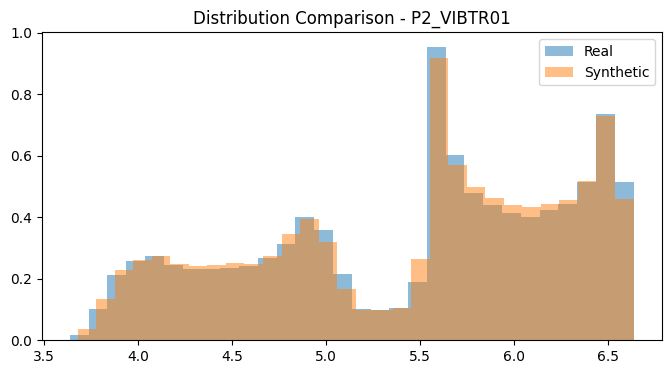

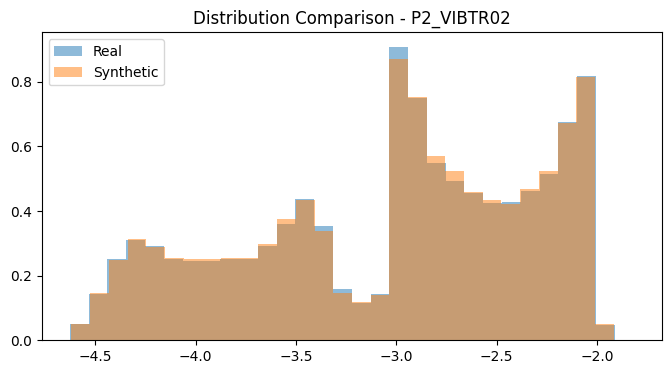

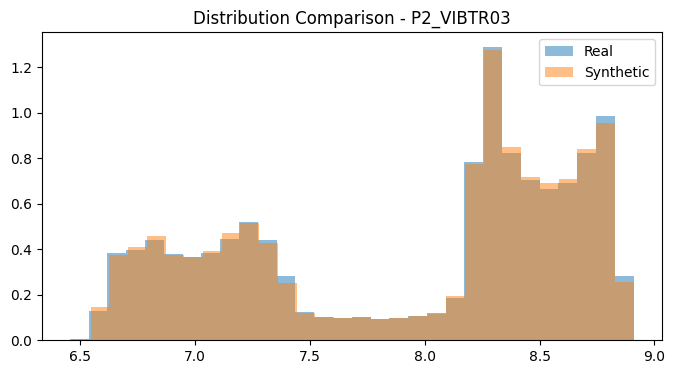

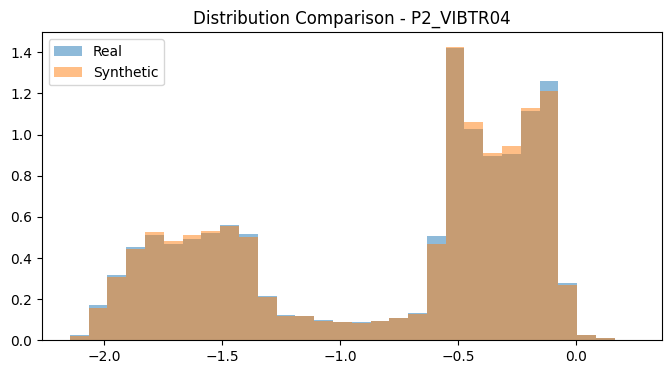

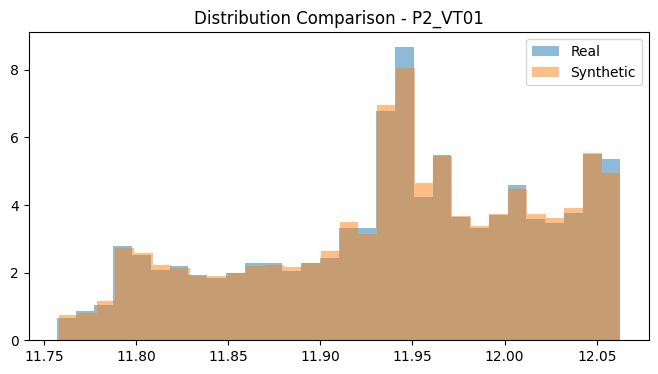

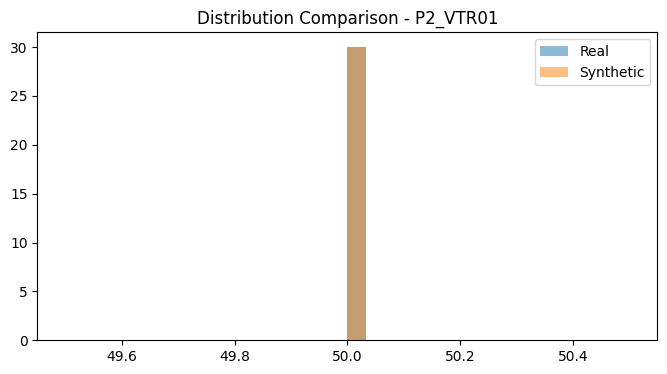

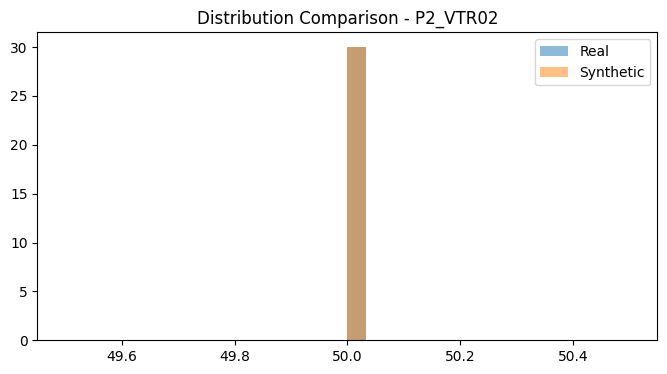

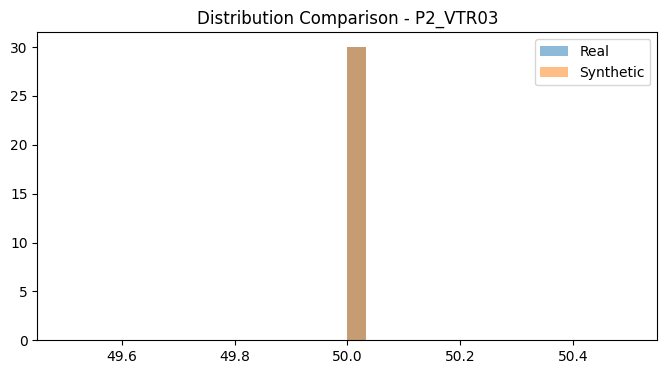

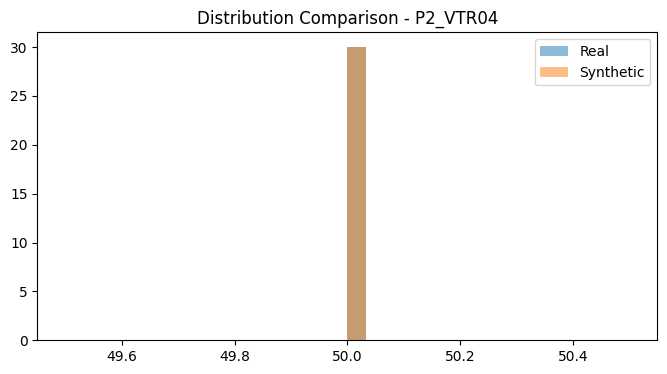

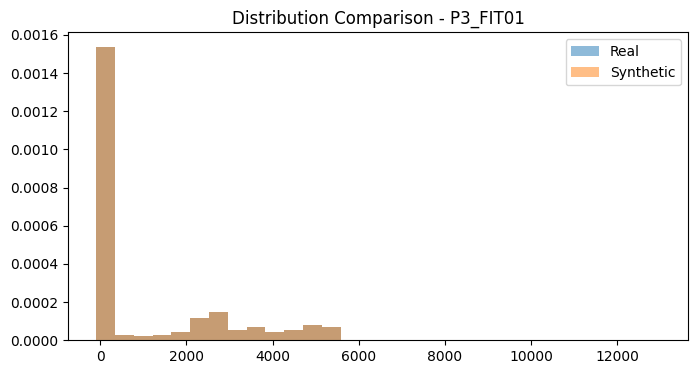

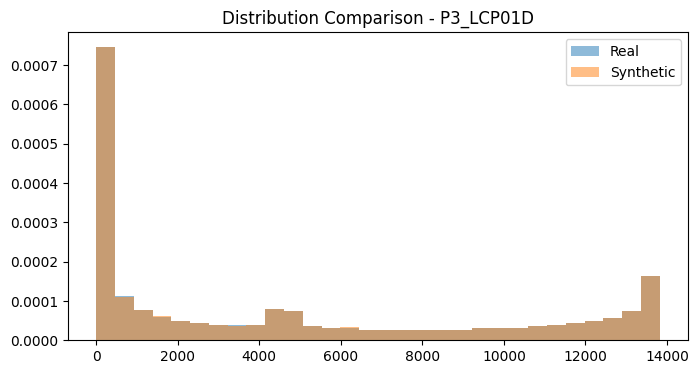

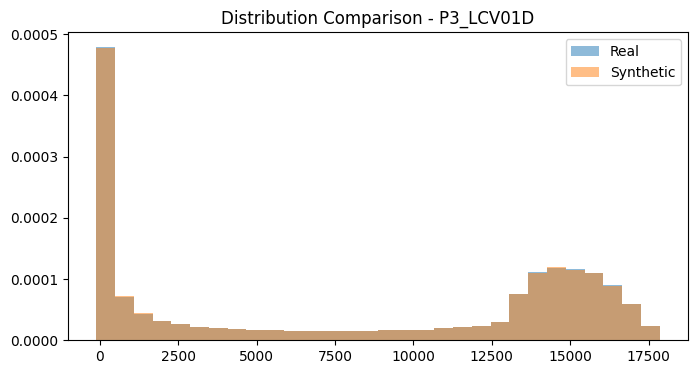

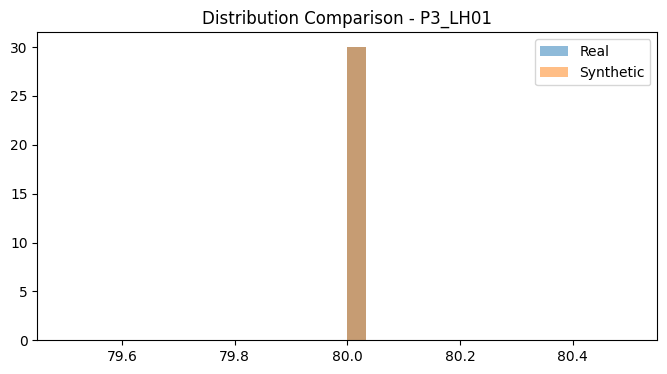

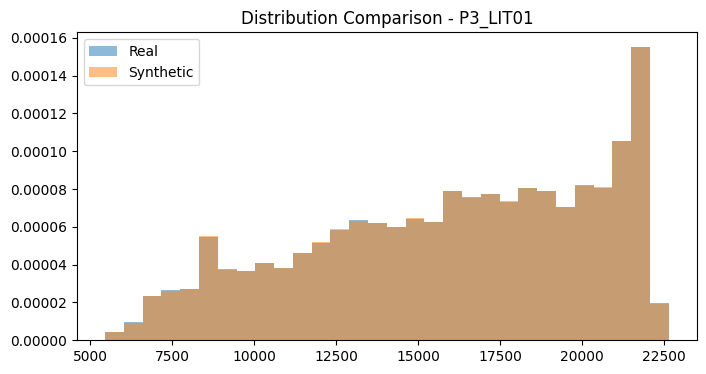

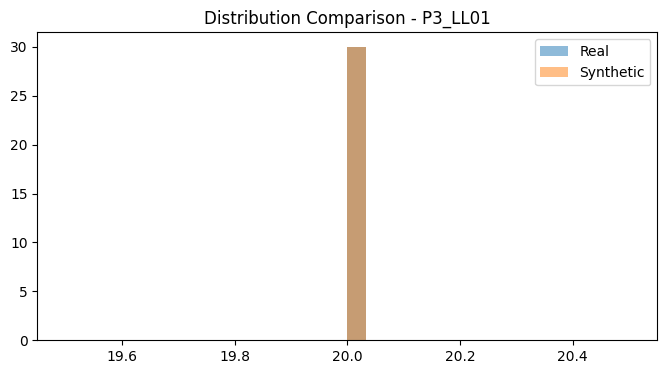

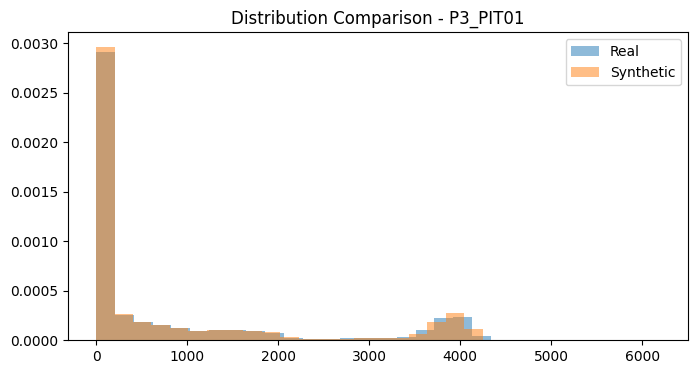

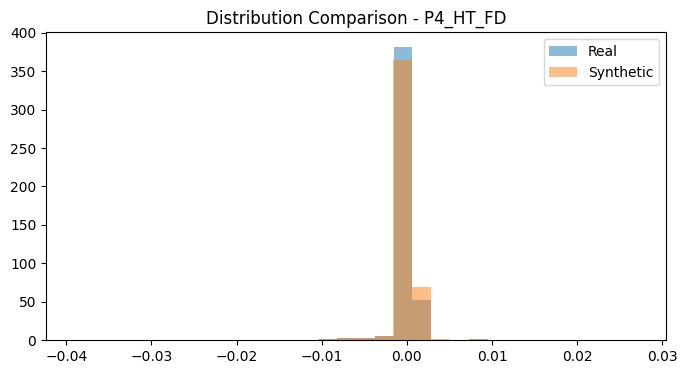

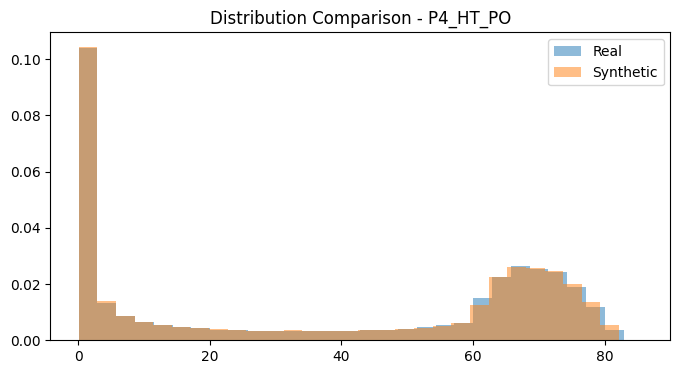

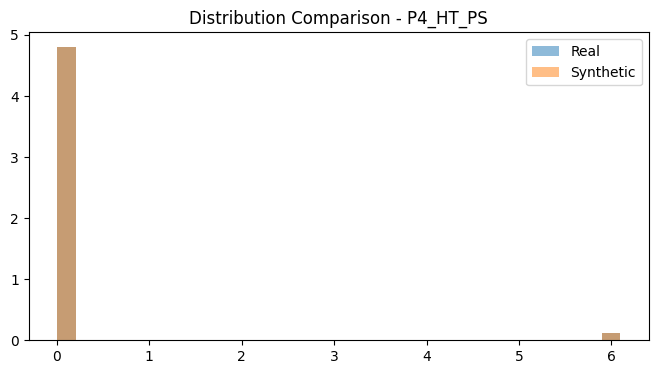

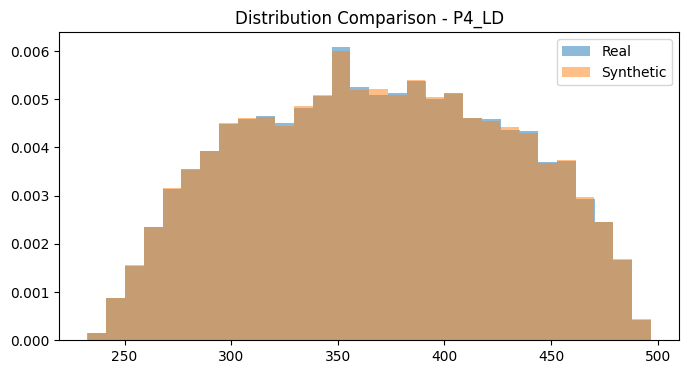

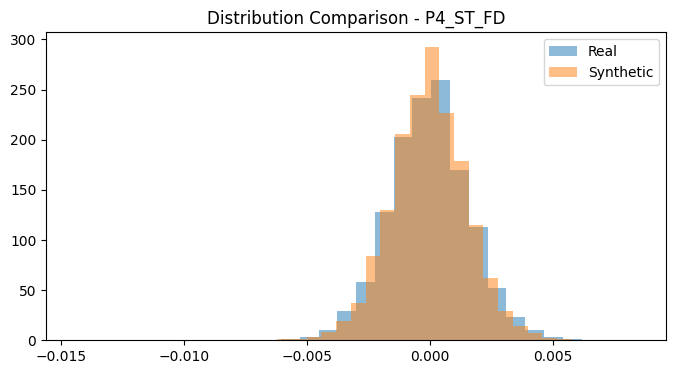

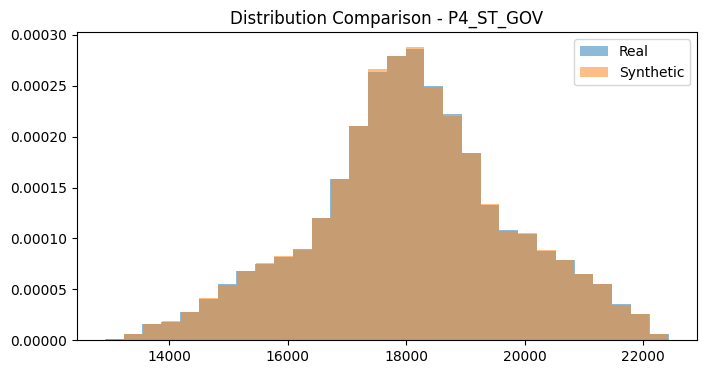

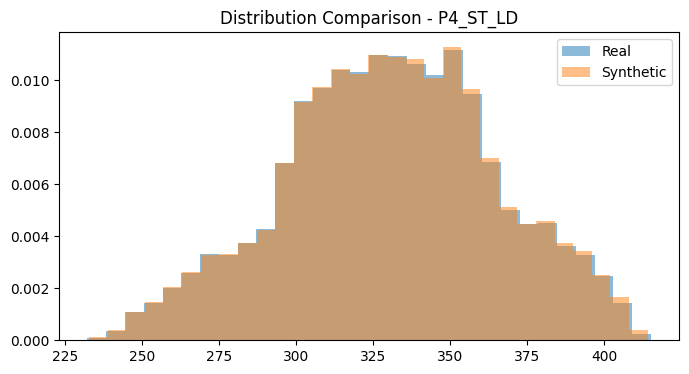

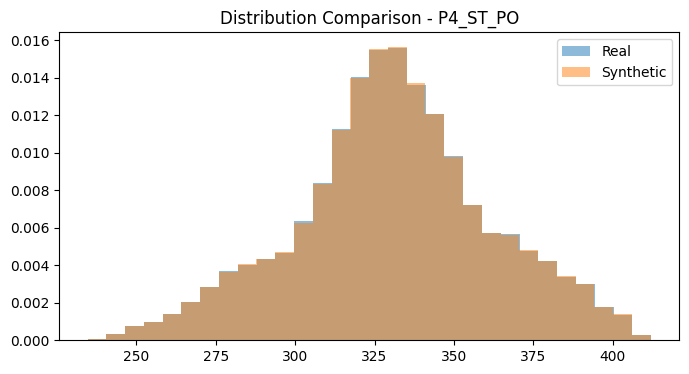

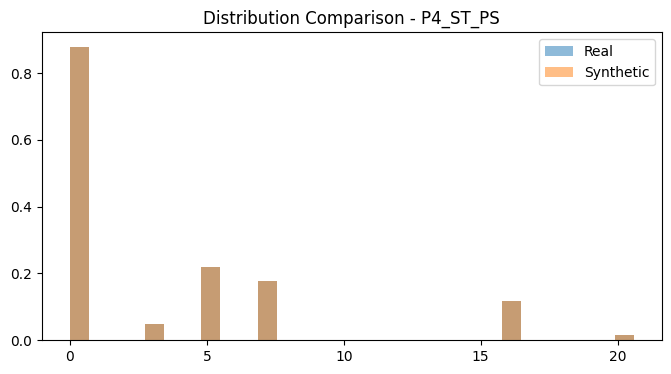

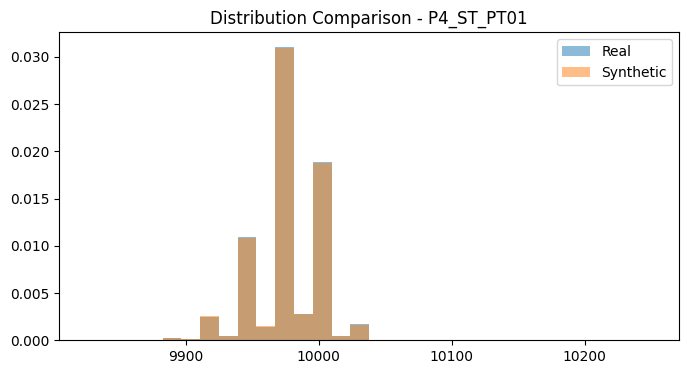

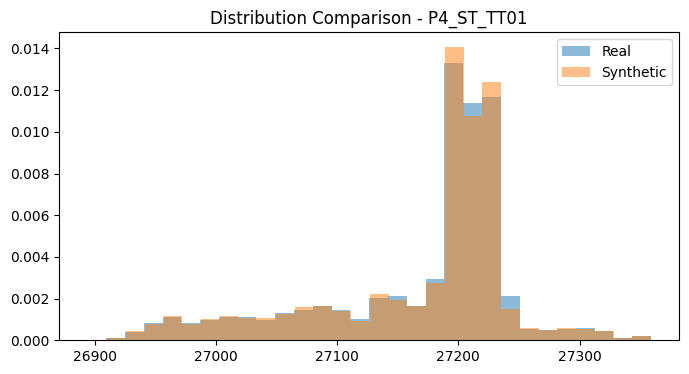

In [36]:
# Source code independently check the performance of the synthetic data. NOT REQUIRED BY THE TASK
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance, entropy

def compare_distributions(real_data, synthetic_data, method='wasserstein'):
    """
    Compare distributions of real and synthetic data.

    :param real_data: pandas.DataFrame, the real dataset
    :param synthetic_data: pandas.DataFrame, the synthetic dataset
    :param method: str, distance metric ('wasserstein' for Earth Mover's Distance, 'kl' for KL Divergence)
    :return: dict, distance values for each feature
    """
    distances = {}
    
    for column in real_data.columns:
        real_dist = real_data[column].values
        synthetic_dist = synthetic_data[column].values
        
        # Compute distance based on selected method
        if method == 'wasserstein':
            distances[column] = wasserstein_distance(real_dist, synthetic_dist)
        elif method == 'kl':
            # Add a small value to avoid log(0) issues in KL Divergence
            distances[column] = entropy(real_dist + 1e-9, synthetic_dist + 1e-9)
    
    return distances

def plot_comparison(real_data, synthetic_data):
    """
    Plot histograms for visual comparison of real and synthetic data distributions.

    :param real_data: pandas.DataFrame, the real dataset
    :param synthetic_data: pandas.DataFrame, the synthetic dataset
    """
    for column in real_data.columns:
        plt.figure(figsize=(8, 4))
        plt.hist(real_data[column], bins=30, alpha=0.5, label='Real', density=True)
        plt.hist(synthetic_data[column], bins=30, alpha=0.3
                 , label='Synthetic', density=True)
        plt.title(f'Distribution Comparison - {column}')
        plt.legend()
        plt.show()

# Usage example:
# Assuming `real_data` and `synthetic_data` are both DataFrames with the same columns
# Compare distributions using Earth Mover's Distance
real_data = pd.read_csv('/kaggle/working/train_4_task_02.csv')
synthetic_data = pd.read_csv('/kaggle/working/k2_synthetic_data.csv')

distances = compare_distributions(real_data, synthetic_data, method='wasserstein')
print("Distance metrics for each feature:", distances)

# Plot distributions for visual comparison
plot_comparison(real_data, synthetic_data)

### Task 2: Similarity of Different Synthetic Datasets
The goal of this task is to analyze the similarity of the three different synthetic datasets that you generated in the previous task and in the previous practical sheet and the corresponding real dataset used for their generation. To this end, you should compute different statistical methods used to identify how much they differentiate from the corresponding real dataset and how much they differentiate between each other. Each of the statistical methods below should be implemented to learn a single model per sensor and/or actuator from a given dataset. In particular, the statistical methods should be as follows:

- a) **MinMax**: This statistic should compute the minimum and maximum values of a given sensor and/or actuator from the real dataset and identify whether and how much a current value for the same sensor and/or actuator observed in each of the synthetic datasets exceeds this range. To compute the predefined range, you should introduce an error margin to the learned thresholds as follows:
$min_{err} = min − \frac{max−min}{2}$ and $max_{err} = max + \frac{max−min}{2}$

- b) **Gradient**: This statistic should identify whether and how much a sensor’s and/or actuator’s slope in a given synthetic dataset exceeds the minimum and maximum slope observed in the real dataset. The Gradient approach assumes that physical readings have continual character, i.e., physical values such as temperatures cannot change at arbitrary speed. To compute the predefined range, you should again introduce an error margin to the learned thresholds as follows: $min_{err} = min − \frac{max−min}{2}$ and $max_{err} = \frac{max + max−min}{2}$ You are not allowed to use any preexisting function from a library for the computation of the gradient.

- c) **Steadytime**: This statistic should identify whether and how much a sensor and/or actuator remains static in a given synthetic dataset, i.e., does not change its value, for a shorter or longer time than the one seen in the real dataset. Since a steady state is difficult to define for noisy sensor data, Steadytime should take only process values into account if the number of distinct values during training is sufficiently small (<= 50). To compute the predefined range, you should again introduce an error margin to the learned thresholds as follows: $min_{err} = min − \frac{max−min}{2}$ and $max_{err} = max + \frac{max−min}{2}$.

- d) **Entropy**: For each dataset (both the real and the synthetic ones), this statistic should identify whether the values for a given sensor and/or actuator repeat often or they are rather unique. For the computation of entropy per sensor/actuator, you should apply Shannon entropy.

After computing and storing all statistics using each of the methods above and the four datasets (three synthetic and one real datasets), you should write a piece of code that plots (i) a cumula- tive distribution function (CDF) for the observed entropy values in each of the four datasets and (ii) a separate complementary cumulative distribution function (CCDF) for each of the other three statistics (i.e., MinMax, Gradient, and Steadytime) showing whether and how much the synthetically generated values from each of the synthetic datasets differentiate from the corre- sponding values in the real dataset. Beside the source code, you should submit all generated plots for this task.

In [1]:
%%writefile task_02.py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import entropy
import seaborn as sns

class DatasetAnalyzer:
    def __init__(self, real_data_path, synthetic_data_paths):
        """
        Initialize analyzer with paths to real and synthetic datasets
        """
        self.real_data = pd.read_csv(real_data_path)
        self.synthetic_datasets = [pd.read_csv(path) for path in synthetic_data_paths]
        
    def analyze_column(self, column_name):
        """
        Analyze a single sensor/actuator column across all datasets
        """
        real_values = self.real_data[column_name].dropna().values
        synthetic_values = [df[column_name].dropna().values for df in self.synthetic_datasets]
        
        return {
            'minmax': self._minmax_stat(real_values, synthetic_values),
            'gradient': self._gradient_stat(real_values, synthetic_values),
            'steadytime': self._steadytime_stat(real_values, synthetic_values),
            'entropy': self._entropy_stat(real_values, synthetic_values)
        }
    
    def _minmax_stat(self, real, synthetic_list):
        """
        Compute MinMax statistic with error margins
        """
        min_real, max_real = np.min(real), np.max(real)
        range_real = max_real - min_real
        
        # Calculate error margins as per requirements
        min_err = min_real - (range_real / 2)
        max_err = max_real + (range_real / 2)
        
        violations = []
        for synthetic in synthetic_list:
            outside_range = np.sum((synthetic < min_err) | (synthetic > max_err))
            violation_rate = outside_range / len(synthetic)
            violations.append(violation_rate)
            
        return violations
    
    def _gradient_stat(self, real, synthetic_list):
        """
        Compute Gradient statistic with error margins
        """
        real_grad = np.diff(real)
        min_grad = np.min(real_grad)
        max_grad = np.max(real_grad)
        range_grad = max_grad - min_grad
        
        min_err = min_grad - (range_grad / 2)
        max_err = max_grad + (range_grad / 2)
        
        violations = []
        for synthetic in synthetic_list:
            synthetic_grad = np.diff(synthetic)
            outside_range = np.sum((synthetic_grad < min_err) | (synthetic_grad > max_err))
            violation_rate = outside_range / len(synthetic_grad)
            violations.append(violation_rate)
            
        return violations
    
    def _steadytime_stat(self, real, synthetic_list):
        """
        Compute Steadytime statistic for process values with <= 50 distinct values
        """
        def get_max_steady_duration(values):
            if len(np.unique(values)) > 50:
                return None
            
            durations = []
            current_duration = 1
            for i in range(1, len(values)):
                if values[i] == values[i-1]:
                    current_duration += 1
                else:
                    durations.append(current_duration)
                    current_duration = 1
            durations.append(current_duration)
            return max(durations)
        
        real_steady = get_max_steady_duration(real)
        if real_steady is None:
            return None
        
        min_err = real_steady / 2
        max_err = real_steady * 2
        
        violations = []
        for synthetic in synthetic_list:
            synthetic_steady = get_max_steady_duration(synthetic)
            if synthetic_steady is None:
                violations.append(0)  # Handle None by setting violation as 0
            else:
                violation = 1 if (synthetic_steady < min_err or synthetic_steady > max_err) else 0
                violations.append(violation)
                
        return violations
    
    def _entropy_stat(self, real, synthetic_list):
        """
        Compute Shannon entropy for all datasets
        """
        def compute_entropy(values):
            hist, _ = np.histogram(values, bins=30, density=True)
            return entropy(hist + 1e-10)  # Avoid log(0)
        
        real_entropy = compute_entropy(real)
        synthetic_entropies = [compute_entropy(synthetic) for synthetic in synthetic_list]
        
        return real_entropy, synthetic_entropies
    
    def plot_statistics(self, column_name, output_dir="plots"):
        """
        Generate and save all required plots for a given sensor/actuator
        """
        import os
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)  # Create directory if it doesn't exist

        results = self.analyze_column(column_name)
        
        # Set style using seaborn API
        sns.set(style='whitegrid')
        
        # 1. CDF for Entropy
        plt.figure(figsize=(10, 6))
        entropies = [results['entropy'][0]] + results['entropy'][1]
        entropies_sorted = np.sort(entropies)
        cdf = np.arange(1, len(entropies_sorted) + 1) / len(entropies_sorted)
        
        plt.plot(entropies_sorted, cdf, 'b-', linewidth=2)
        plt.xlabel('Entropy')
        plt.ylabel('Cumulative Probability')
        plt.title(f'CDF of Entropy - {column_name}')
        plt.grid(True)
        # Save plot
        plt.savefig(f"{output_dir}/{column_name}_entropy_cdf.png")
        plt.close()  # Close the figure to free memory
        
        # 2. Bar plots for MinMax, Gradient, and Steadytime
        metrics = ['minmax', 'gradient', 'steadytime']
        
        for metric in metrics:
            if results[metric] is not None:
                plt.figure(figsize=(10, 6))
                data_to_plot = [0 if v is None else v for v in results[metric]]  # Handle None
                plt.bar(range(len(data_to_plot)), data_to_plot, color='skyblue', edgecolor='black')
                plt.xlabel('Synthetic Dataset Index')
                plt.ylabel('Violation Rate')
                plt.title(f'{metric.capitalize()} Violations - {column_name}')
                plt.xticks(range(len(data_to_plot)))
                plt.grid(True, axis='y')
                # Save plot
                plt.savefig(f"{output_dir}/{column_name}_{metric}_violations.png")
                plt.close()  # Close the figure to free memory


# Example usage
if __name__ == "__main__":
    real_data_path = "/kaggle/working/train_4_task_02.csv"
    synthetic_paths = [
        "/kaggle/working/k2_synthetic_data.csv",
        "/kaggle/working/k5_synthetic_data.csv"
    ]
    
    analyzer = DatasetAnalyzer(real_data_path, synthetic_paths)
    
    for column in analyzer.real_data.columns:
        print(f"\nAnalyzing {column}...")
        analyzer.plot_statistics(column, output_dir="output_plots")


Overwriting task_02.py


In [2]:
!python task_02.py


Analyzing P1_B2004...

Analyzing P1_B2016...

Analyzing P1_B3004...

Analyzing P1_B3005...

Analyzing P1_B4002...

Analyzing P1_B4005...

Analyzing P1_B400B...

Analyzing P1_B4022...

Analyzing P1_FCV01D...

Analyzing P1_FCV01Z...

Analyzing P1_FCV02D...

Analyzing P1_FCV02Z...

Analyzing P1_FCV03D...

Analyzing P1_FCV03Z...

Analyzing P1_FT01...

Analyzing P1_FT01Z...

Analyzing P1_FT02...

Analyzing P1_FT02Z...

Analyzing P1_FT03...

Analyzing P1_FT03Z...

Analyzing P1_LCV01D...

Analyzing P1_LCV01Z...

Analyzing P1_LIT01...

Analyzing P1_PCV01D...

Analyzing P1_PCV01Z...

Analyzing P1_PCV02D...

Analyzing P1_PCV02Z...

Analyzing P1_PIT01...

Analyzing P1_PIT01_HH...

Analyzing P1_PIT02...

Analyzing P1_PP01AD...

Analyzing P1_PP01AR...

Analyzing P1_PP01BD...

Analyzing P1_PP01BR...

Analyzing P1_PP02D...

Analyzing P1_PP02R...

Analyzing P1_PP04...

Analyzing P1_PP04SP...

Analyzing P1_SOL01D...

Analyzing P1_SOL03D...

Analyzing P1_STSP...

Analyzing P1_TIT01...

Analyzing P1_TIT

In [9]:
synthetic_1 = pd.read_csv('/kaggle/working/k2_synthetic_data.csv')
synthetic_2 = pd.read_csv('/kaggle/working/k5_synthetic_data.csv')
real_data = pd.read_csv('/kaggle/working/train_4_task_02.csv')

In [19]:
synthetic_1.head(),synthetic_2.head(),real_data.head()

(   P1_B2004  P1_B2016   P1_B3004   P1_B3005  P1_B4002  P1_B4005   P1_B400B  \
 0   0.11126   1.02040  452.41907  972.89972  25.69677  10.72952  150.15547   
 1   0.11126   1.01915  452.41907  972.89972  25.69677  10.83733   49.85335   
 2   0.11126   1.01959  452.41907  972.89972  25.69677  10.99563   42.88994   
 3   0.11126   1.01834  452.41907  972.89972  25.69677  10.99790   42.90174   
 4   0.11126   1.01686  452.41907  972.89972  25.69677  11.11872  167.03827   
 
    P1_B4022  P1_FCV01D  P1_FCV01Z  ...  P4_HT_PO  P4_HT_PS      P4_LD  \
 0  29.22724    9.07711    5.86853  ...  59.29907      -0.0  360.82178   
 1  29.22304    9.36480    5.86090  ...  59.35327      -0.0  360.36963   
 2  29.22595    9.40721    8.25954  ...  59.48131      -0.0  360.01296   
 3  29.22037    7.63938    9.00421  ...  59.49792      -0.0  360.18878   
 4  29.21541    6.89269    9.28650  ...  59.53412      -0.0  359.77289   
 
    P4_ST_FD  P4_ST_GOV   P4_ST_LD   P4_ST_PO  P4_ST_PS  P4_ST_PT01  P4_ST_TT0

# SHEET 01 REVISION
### Generating synthetic data from GAN

In [19]:
%%writefile gan.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp  # For Kolmogorov-Smirnov test
from sklearn.preprocessing import MinMaxScaler

# Hyperparameters
FEATURE_DIM = 32
INPUT_DIM = 100  # Noise vector size for generator input
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.0002
BATCH_SIZE = 64
EPOCHS = 100

# Check if GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Discriminator Model (CNN-based)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, FEATURE_DIM, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(FEATURE_DIM, FEATURE_DIM * 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(DROPOUT_RATE),
            nn.Conv1d(FEATURE_DIM * 2, FEATURE_DIM * 4, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(DROPOUT_RATE),
            nn.Conv1d(FEATURE_DIM * 4, FEATURE_DIM * 8, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(DROPOUT_RATE),
            nn.Conv1d(FEATURE_DIM * 8, FEATURE_DIM * 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(DROPOUT_RATE),
            nn.Conv1d(FEATURE_DIM * 16, FEATURE_DIM * 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(FEATURE_DIM * 32 * 2, FEATURE_DIM * 16),
            nn.ReLU(),
            nn.Linear(FEATURE_DIM * 16, FEATURE_DIM * 8),
            nn.ReLU(),
            nn.Linear(FEATURE_DIM * 8, FEATURE_DIM * 4),
            nn.ReLU(),
            nn.Linear(FEATURE_DIM * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

# Generator Model (Reverse CNN with Deconvolution)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc_layers = nn.Sequential(
            nn.Linear(INPUT_DIM, FEATURE_DIM * 16),
            nn.ReLU(),
            nn.Linear(FEATURE_DIM * 16, FEATURE_DIM * 8),
            nn.ReLU(),
            nn.Linear(FEATURE_DIM * 8, FEATURE_DIM * 4),
            nn.ReLU()
        )
        
        self.deconv_layers = nn.Sequential(
            nn.Upsample(scale_factor=2), 
            nn.ConvTranspose1d(FEATURE_DIM * 4, FEATURE_DIM * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(FEATURE_DIM * 2, FEATURE_DIM, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(FEATURE_DIM, FEATURE_DIM, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(FEATURE_DIM, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.fc_layers(x)
        x = x.unsqueeze(2)
        return self.deconv_layers(x)

# Training the GAN
def train_gan(real_data, num_epochs=EPOCHS):
    # Convert real_data to NumPy array and then to PyTorch tensor
    real_data = torch.tensor(real_data.values, dtype=torch.float32).to(device)
    
    # Initialize the discriminator and generator
    discriminator = Discriminator().to(device)
    generator = Generator().to(device)

    # Define the loss function and optimizer
    criterion = nn.BCELoss()
    d_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)
    g_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE)

    # Training loop
    for epoch in range(num_epochs):
        # Train the discriminator
        discriminator.zero_grad()
        
        # Train on real data
        real_output = discriminator(real_data.unsqueeze(1))
        real_loss = criterion(real_output, torch.ones_like(real_output))
        
        # Train on fake data
        noise = torch.randn(BATCH_SIZE, INPUT_DIM, device=device)
        fake_data = generator(noise)
        fake_output = discriminator(fake_data.detach())
        fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
        
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()
        
        # Train the generator
        generator.zero_grad()
        noise = torch.randn(BATCH_SIZE, INPUT_DIM, device=device)
        fake_data = generator(noise)
        fake_output = discriminator(fake_data)
        g_loss = criterion(fake_output, torch.ones_like(fake_output))
        g_loss.backward()
        g_optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
    
    return generator

# Synthetic data generation
def generate_synthetic_data(generator, num_samples, device=device):
    noise = torch.randn(num_samples, INPUT_DIM, device=device)
    synthetic_data = generator(noise).detach().cpu().numpy()
    return synthetic_data

# Kolmogorov-Smirnov test
def compute_ks_test(dataset1, dataset2):
    num_sensors = dataset1.shape[1]
    ks_stats = []
    ks_pvalues = []
    for i in range(num_sensors):
        stat, pvalue = ks_2samp(dataset1[:, i], dataset2[:, i])
        ks_stats.append(stat)
        ks_pvalues.append(pvalue)
    return ks_stats, ks_pvalues

# Hyperparameter tuning
def tune_hyperparameters(real_data):
    best_params = None
    best_score = float('-inf')

    for feature_dim in [16, 32, 64]:
        for input_dim in [50, 100, 150]:
            for dropout_rate in [0.2, 0.3, 0.4]:
                for learning_rate in [0.0001, 0.0002, 0.0005]:
                    for batch_size in [32, 64, 128]:
                        global FEATURE_DIM, INPUT_DIM, DROPOUT_RATE, LEARNING_RATE, BATCH_SIZE
                        FEATURE_DIM = feature_dim
                        INPUT_DIM = input_dim
                        DROPOUT_RATE = dropout_rate
                        LEARNING_RATE = learning_rate
                        BATCH_SIZE = batch_size

                        generator = train_gan(real_data)
                        synthetic_data = generate_synthetic_data(generator, real_data.shape[0])
                        synthetic_data = synthetic_data.reshape(synthetic_data.shape[0], -1)
                        ks_stats, ks_pvalues = compute_ks_test(real_data.values, synthetic_data)
                        num_passing = sum(p > 0.03 and s < 0.15 for s, p in zip(ks_stats, ks_pvalues))
                        score = num_passing / len(ks_stats)

                        if score > best_score:
                            best_params = {
                                'feature_dim': feature_dim,
                                'input_dim': input_dim,
                                'dropout_rate': dropout_rate,
                                'learning_rate': learning_rate,
                                'batch_size': batch_size
                            }
                            best_score = score

    return best_params

# Load the original ICS dataset using Pandas
original_data = pd.read_csv('/kaggle/working/train_4_task_02.csv')  # Assuming your data is in a CSV file

# Hyperparameter tuning
t_results = tune_hyperparameters(original_data)
print(t_results)

Overwriting gan.py


In [20]:
!python gan.py

Epoch [10/100], D_loss: 0.3299, G_loss: 0.7280
Epoch [20/100], D_loss: 0.3286, G_loss: 0.7307
Epoch [30/100], D_loss: 0.3270, G_loss: 0.7342
Epoch [40/100], D_loss: 0.3253, G_loss: 0.7380
Epoch [50/100], D_loss: 0.3236, G_loss: 0.7416
Epoch [60/100], D_loss: 0.3220, G_loss: 0.7453
Epoch [70/100], D_loss: 0.3202, G_loss: 0.7493
Epoch [80/100], D_loss: 0.3181, G_loss: 0.7540
Epoch [90/100], D_loss: 0.3158, G_loss: 0.7593
Epoch [100/100], D_loss: 0.3131, G_loss: 0.7654
Epoch [10/100], D_loss: 0.3772, G_loss: 0.6357
Epoch [20/100], D_loss: 0.3749, G_loss: 0.6400
Epoch [30/100], D_loss: 0.3723, G_loss: 0.6448
Epoch [40/100], D_loss: 0.3695, G_loss: 0.6499
Epoch [50/100], D_loss: 0.3666, G_loss: 0.6553
Epoch [60/100], D_loss: 0.3631, G_loss: 0.6619
Epoch [70/100], D_loss: 0.3591, G_loss: 0.6695
Epoch [80/100], D_loss: 0.3548, G_loss: 0.6777
Epoch [90/100], D_loss: 0.3502, G_loss: 0.6873
Epoch [100/100], D_loss: 0.3426, G_loss: 0.7032
Epoch [10/100], D_loss: 0.3294, G_loss: 0.7291
Epoch [20/1

In [11]:
synth = pd.read_csv('/kaggle/working/synthetic_ics_data.csv')

In [12]:
synth.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.018614,-0.155420,0.078762,-0.245235,0.410271,-0.156495,0.228503,-0.311890,0.469413,-0.101990,...,0.061787,-0.288785,0.491451,-0.131991,0.218694,-0.241505,0.412645,-0.292678,0.325325,-0.159704
1,0.014415,-0.162093,0.069834,-0.241349,0.383816,-0.157728,0.213347,-0.308295,0.442740,-0.104913,...,0.042828,-0.273442,0.454557,-0.151034,0.186213,-0.235197,0.370693,-0.289258,0.291888,-0.161518
2,0.022398,-0.152467,0.084775,-0.244338,0.432479,-0.155580,0.242318,-0.317987,0.489825,-0.095254,...,0.065874,-0.293483,0.512927,-0.126659,0.221689,-0.244031,0.434554,-0.297564,0.338279,-0.160720
3,0.033026,-0.147842,0.100506,-0.254662,0.474966,-0.151554,0.268224,-0.333077,0.533390,-0.081313,...,0.080138,-0.300319,0.545793,-0.112199,0.247174,-0.256956,0.465877,-0.299574,0.366535,-0.164949
4,0.048016,-0.139034,0.115749,-0.262931,0.533949,-0.145958,0.306562,-0.349883,0.592366,-0.066242,...,0.114380,-0.315143,0.607441,-0.088421,0.298513,-0.274437,0.543416,-0.313188,0.416265,-0.170146


In [34]:
%%writefile gan_hp.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp  # For Kolmogorov-Smirnov test
from sklearn.preprocessing import MinMaxScaler

# Hyperparameters
FEATURE_DIM = 32
INPUT_DIM = 100  # Noise vector size for generator input
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.0002
BATCH_SIZE = 64
EPOCHS = 100
PATIENCE = 10  # Early stopping patience

# Check if GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Discriminator Model (CNN-based)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, FEATURE_DIM, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(FEATURE_DIM, FEATURE_DIM * 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(DROPOUT_RATE),
            nn.Conv1d(FEATURE_DIM * 2, FEATURE_DIM * 4, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(DROPOUT_RATE),
            nn.Conv1d(FEATURE_DIM * 4, FEATURE_DIM * 8, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(DROPOUT_RATE),
            nn.Conv1d(FEATURE_DIM * 8, FEATURE_DIM * 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(DROPOUT_RATE),
            nn.Conv1d(FEATURE_DIM * 16, FEATURE_DIM * 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(FEATURE_DIM * 32 * 2, FEATURE_DIM * 16),
            nn.ReLU(),
            nn.Linear(FEATURE_DIM * 16, FEATURE_DIM * 8),
            nn.ReLU(),
            nn.Linear(FEATURE_DIM * 8, FEATURE_DIM * 4),
            nn.ReLU(),
            nn.Linear(FEATURE_DIM * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

# Generator Model (Reverse CNN with Deconvolution)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(INPUT_DIM, FEATURE_DIM * 16),
            nn.ReLU(),
            nn.Linear(FEATURE_DIM * 16, FEATURE_DIM * 8),
            nn.ReLU(),
            nn.Linear(FEATURE_DIM * 8, FEATURE_DIM * 4),
            nn.ReLU()
        )
        self.deconv_layers = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(FEATURE_DIM * 4, FEATURE_DIM * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(FEATURE_DIM * 2, FEATURE_DIM, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(FEATURE_DIM, FEATURE_DIM, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Adjust final ConvTranspose1d layer to output 86 features
            nn.ConvTranspose1d(FEATURE_DIM, 1, kernel_size=4, stride=2, padding=1), 
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc_layers(x)
        x = x.unsqueeze(2)
        return self.deconv_layers(x)[:, :, :86]  # Ensure output has exactly 86 features

# Training the GAN with early stopping
def train_gan(real_data, num_epochs=EPOCHS, patience=PATIENCE):
    # Normalize the data
    scaler = MinMaxScaler()
    real_data = scaler.fit_transform(real_data)
    
    # Convert real_data to NumPy array and then to PyTorch tensor
    real_data = torch.tensor(real_data, dtype=torch.float32).to(device)
    
    # Initialize the discriminator and generator
    discriminator = Discriminator().to(device)
    generator = Generator().to(device)

    # Define the loss function and optimizer
    criterion = nn.BCELoss()
    d_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)
    g_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE)

    # Early stopping variables
    best_g_loss = float('inf')
    epochs_no_improve = 0

    # Training loop
    for epoch in range(num_epochs):
        # Train the discriminator
        discriminator.zero_grad()
        
        # Train on real data
        real_output = discriminator(real_data.unsqueeze(1))
        real_loss = criterion(real_output, torch.ones_like(real_output))
        
        # Train on fake data
        noise = torch.randn(BATCH_SIZE, INPUT_DIM, device=device)
        fake_data = generator(noise)
        fake_output = discriminator(fake_data.detach())
        fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
        
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()
        
        # Train the generator
        generator.zero_grad()
        noise = torch.randn(BATCH_SIZE, INPUT_DIM, device=device)
        fake_data = generator(noise)
        fake_output = discriminator(fake_data)
        g_loss = criterion(fake_output, torch.ones_like(fake_output))
        g_loss.backward()
        g_optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

        # Early stopping check
        if g_loss.item() < best_g_loss:
            best_g_loss = g_loss.item()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    return generator, scaler

# Synthetic data generation
def generate_synthetic_data(generator, num_samples, scaler, device=device):
    noise = torch.randn(num_samples, INPUT_DIM, device=device)
    synthetic_data = generator(noise).detach().cpu().numpy()
    synthetic_data = synthetic_data.reshape(synthetic_data.shape[0], -1)
    synthetic_data = scaler.inverse_transform(synthetic_data)  # Denormalize the data
    return synthetic_data

# Kolmogorov-Smirnov test
def compute_ks_test(dataset1, dataset2):
    num_sensors = dataset1.shape[1]
    ks_stats = []
    ks_pvalues = []
    for i in range(num_sensors):
        stat, pvalue = ks_2samp(dataset1[:, i], dataset2[:, i])
        ks_stats.append(stat)
        ks_pvalues.append(pvalue)
    return ks_stats, ks_pvalues

# Hyperparameter tuning
def tune_hyperparameters(real_data):
    best_params = None
    best_score = float('-inf')

    for feature_dim in [16, 32, 64]:
        for input_dim in [50, 100, 150]:
            for dropout_rate in [0.2, 0.3, 0.4]:
                for learning_rate in [0.0001, 0.0002, 0.0005]:
                    for batch_size in [32, 64, 128]:
                        global FEATURE_DIM, INPUT_DIM, DROPOUT_RATE, LEARNING_RATE, BATCH_SIZE
                        FEATURE_DIM = feature_dim
                        INPUT_DIM = input_dim
                        DROPOUT_RATE = dropout_rate
                        LEARNING_RATE = learning_rate
                        BATCH_SIZE = batch_size

                        generator, scaler = train_gan(real_data)
                        synthetic_data = generate_synthetic_data(generator, real_data.shape[0], scaler)
                        ks_stats, ks_pvalues = compute_ks_test(real_data.values, synthetic_data)
                        num_passing = sum(p > 0.03 and s < 0.15 for s, p in zip(ks_stats, ks_pvalues))
                        score = num_passing / len(ks_stats)

                        if score > best_score:
                            best_params = {
                                'feature_dim': feature_dim,
                                'input_dim': input_dim,
                                'dropout_rate': dropout_rate,
                                'learning_rate': learning_rate,
                                'batch_size': batch_size
                            }
                            best_score = score

    return best_params

# Load the original ICS dataset using Pandas
original_data = pd.read_csv('/kaggle/working/train_4_task_02.csv')  # Assuming your data is in a CSV file

# Hyperparameter tuning
t_results = tune_hyperparameters(original_data)
print("Best Hyperparameters:", t_results)

# Set the best hyperparameters
FEATURE_DIM = t_results['feature_dim']
INPUT_DIM = t_results['input_dim']
DROPOUT_RATE = t_results['dropout_rate']
LEARNING_RATE = t_results['learning_rate']
BATCH_SIZE = t_results['batch_size']

# Train the GAN with the best hyperparameters
generator, scaler = train_gan(original_data.values)

# Save the generator weights
torch.save(generator.state_dict(), 'generator_weights_best.pth')

# Generate synthetic data
synthetic_data = generate_synthetic_data(generator, original_data.shape[0], scaler)

# Save the synthetic data
pd.DataFrame(synthetic_data).to_csv('synthetic_ics_data_best.csv', index=False)

Overwriting gan_hp.py


In [35]:
!python gan_hp.py

Epoch [10/100], D_loss: 0.6925, G_loss: 0.6911
Early stopping at epoch 11
Epoch [10/100], D_loss: 0.6940, G_loss: 0.7404
Epoch [20/100], D_loss: 0.6927, G_loss: 0.7325
Epoch [30/100], D_loss: 0.6885, G_loss: 0.7298
Early stopping at epoch 38
Epoch [10/100], D_loss: 0.6930, G_loss: 0.6603
Early stopping at epoch 11
Epoch [10/100], D_loss: 0.6896, G_loss: 0.7295
Early stopping at epoch 17
Epoch [10/100], D_loss: 0.6921, G_loss: 0.7173
Epoch [20/100], D_loss: 0.6793, G_loss: 0.7265
Early stopping at epoch 24
Epoch [10/100], D_loss: 0.6893, G_loss: 0.6895
Early stopping at epoch 11
Epoch [10/100], D_loss: 0.6867, G_loss: 0.6993
Early stopping at epoch 15
Epoch [10/100], D_loss: 0.6768, G_loss: 0.7205
Early stopping at epoch 11
Epoch [10/100], D_loss: 0.6765, G_loss: 0.7223
Early stopping at epoch 17
Epoch [10/100], D_loss: 0.6945, G_loss: 0.6389
Early stopping at epoch 11
Epoch [10/100], D_loss: 0.6929, G_loss: 0.7143
Epoch [20/100], D_loss: 0.6909, G_loss: 0.7113
Early stopping at epoch 2

In [2]:
!pip install ctgan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.7 MB/s eta 0:00:00a 0:00:01


In [3]:
# Using CTGAN to generate the synthetic data. 
import pandas as pd
from ctgan import CTGAN
import torch

# File path for the dataset
file_path = '/kaggle/working/train_4_task_02.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Identify discrete columns (customize as needed based on earlier analysis)
discrete_columns = [
    'P4_ST_PS',
    'P4_HT_PS',
    'P3_LL01',
    'P3_LH01',
    'P2_VTR01',
    'P2_VTR02',
    'P2_VTR03',
    'P2_VTR04',
    'P2_TripEx'
]
# Add more discrete columns based on your dataset characteristics.

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the CTGAN model
model = CTGAN(cuda=torch.cuda.is_available())

# Fit the CTGAN model to the dataset
print("Training CTGAN...")
model.fit(data, discrete_columns=discrete_columns)
print("Training complete.")

# Generate synthetic data
num_samples = data.shape[0]  # Generate the same number of rows as the original dataset
synthetic_data = model.sample(num_samples)

# Save synthetic data to a CSV file
synthetic_data_file = '/kaggle/working/synthetic_data-HU.csv'
synthetic_data.to_csv(synthetic_data_file, index=False)
print(f"Synthetic data saved to {synthetic_data_file}")

# Optional: Display first few rows of synthetic data
print(synthetic_data.head())

Using device: cuda
Training CTGAN...


/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Training complete.
Synthetic data saved to /kaggle/working/synthetic_data-HU.csv
   P1_B2004  P1_B2016    P1_B3004     P1_B3005   P1_B4002    P1_B4005  \
0  0.100966  1.092626  489.668767   892.811990  32.010268  100.040420   
1  0.111853  1.125693  450.177499   973.220005  25.684395   11.581240   
2  0.186813  0.972202  450.591820   985.003601  33.013149  100.110151   
3  0.155754  1.130962  447.786810  1029.486413  33.007379  100.078914   
4  0.154125  1.315449  444.879430  1029.606001  26.114231    7.532547   

      P1_B400B   P1_B4022   P1_FCV01D   P1_FCV01Z  ...   P4_HT_PO  P4_HT_PS  \
0  3166.248738  35.115333   85.549928   95.705831  ...  61.961390       0.0   
1   794.868235  29.157939   15.833443   12.249143  ...  68.856547       0.0   
2  3174.961429  35.943555  100.082000  100.463154  ...   0.219004       0.0   
3  3181.196037  36.741928  100.129245  100.276674  ...  19.709648       0.0   
4  3156.358618  37.176071    6.872619    5.816035  ...  67.123982       0.0   

     

In [6]:
synthetic_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,34,?,253874,HS-grad,10,Married-civ-spouse,Adm-clerical,Husband,Other,Female,121,2,50,Mexico,>50K
1,69,Private,356617,Doctorate,13,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,-31,-1,50,Cuba,>50K
2,33,Federal-gov,314310,Masters,11,Never-married,Handlers-cleaners,Other-relative,Black,Female,-10,4,40,Scotland,<=50K
3,51,?,196364,HS-grad,15,Married-spouse-absent,Machine-op-inspct,Husband,White,Male,-58,6,40,United-States,<=50K
4,40,Private,254645,HS-grad,9,Never-married,Exec-managerial,Wife,White,Male,-58,1,52,United-States,<=50K


In [3]:
# Cleaning Data test

# Import necessary libraries
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/hai-security-dataset/hai-22.04/train4.csv')
df2 = pd.read_csv('/kaggle/input/hai-security-dataset/hai-22.04/train1.csv')
df3 = pd.read_csv('/kaggle/input/hai-security-dataset/hai-22.04/train2.csv')
df4 = pd.read_csv('/kaggle/input/hai-security-dataset/hai-22.04/train3.csv')

# Check if there are any missing values and handle them if necessary
if df.isnull().sum().any():
    df = df.fillna(df.mean())  # Alternatively, handle missing values as required

# Convert the 'timestamp' column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
df3['timestamp'] = pd.to_datetime(df3['timestamp'])
df4['timestamp'] = pd.to_datetime(df4['timestamp'])

# Define the start and end times for a 24-hour period from the first timestamp
start_time = df['timestamp'].iloc[0]
start_time2 = df2['timestamp'].iloc[0]
start_time3 = df3['timestamp'].iloc[0]
start_time4 = df4['timestamp'].iloc[0]
end_time = start_time + pd.Timedelta(days=1)
end_time2 = start_time2 + pd.Timedelta(days=1)
end_time3 = start_time3 + pd.Timedelta(days=1)
end_time4 = start_time4 + pd.Timedelta(days=1)

# Filter the dataset for this 24-hour range
train_data_one_day = df[(df['timestamp'] >= start_time) & (df['timestamp'] < end_time)]
train_data_one_day2 = df2[(df2['timestamp'] >= start_time2) & (df2['timestamp'] < end_time2)]
train_data_one_day3 = df3[(df3['timestamp'] >= start_time3) & (df3['timestamp'] < end_time3)]
train_data_one_day4 = df4[(df4['timestamp'] >= start_time4) & (df4['timestamp'] < end_time4)]

# Select the features and exclude the 'Attack' column for normalization
features = train_data_one_day.drop(columns=['Attack','timestamp'])
features2 = train_data_one_day2.drop(columns=['Attack','timestamp'])
features3 = train_data_one_day3.drop(columns=['Attack','timestamp'])
features4 = train_data_one_day4.drop(columns=['Attack','timestamp'])

features.to_csv('/kaggle/working/humm_4.csv', index=False)
features2.to_csv('/kaggle/working/humm_4_2.csv', index=False)
features3.to_csv('/kaggle/working/humm_4_3.csv', index=False)
features4.to_csv('/kaggle/working/humm_4_4.csv', index=False)

In [2]:
%%writefile testing_class_task_01.py
import sys
import numpy as np
import pandas as pd
import argparse
from joblib import Parallel, delayed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from loguru import logger
from typing import Tuple, Union, List

# Configure Loguru
logger.remove()
logger.add(sys.stdout, level="INFO", filter=lambda record: record["level"].name == "INFO")

class SyntheticDataGenerator:
    """A class to generate synthetic data using nearest neighbor interpolation."""
    
    def __init__(self, normalization_method: str = 'min_max'):
        """
        Initialize the SyntheticDataGenerator.
        
        Args:
            normalization_method: The method to use for data normalization ('min_max' or 'z_score')
        """
        self.normalization_method = normalization_method
        self.scaler = MinMaxScaler() if normalization_method == 'min_max' else StandardScaler()
        self.original_data = None
        self.normalized_data = None
    
    def load_dataset(self, filepath: str) -> pd.DataFrame:
        """
        Load dataset from a CSV file.
        
        Args:
            filepath: Path to the CSV file
            
        Returns:
            Loaded DataFrame
        """
        logger.info(f"Loading dataset from: {filepath}")
        self.original_data = pd.read_csv(filepath)
        return self.original_data
    
    def normalize_data(self) -> np.ndarray:
        """
        Normalize the loaded dataset.
        
        Returns:
            Normalized data as numpy array
        """
        if self.original_data is None:
            raise ValueError("No data loaded. Please call load_dataset first.")
            
        logger.info(f"Normalizing data using '{self.normalization_method}' method")
        self.normalized_data = self.scaler.fit_transform(self.original_data)
        return self.normalized_data
    
    @staticmethod
    def get_decimal_precision(series: pd.Series) -> int:
        """
        Determine decimal precision for a pandas Series.
        
        Args:
            series: Input pandas Series
            
        Returns:
            Maximum decimal precision found in the series
        """
        precisions = series.astype(str).apply(lambda x: len(x.split('.')[-1]) if '.' in x else 0)
        return precisions.max()
    
    def inverse_normalize(self, synthetic_data: np.ndarray) -> pd.DataFrame:
        """
        Convert normalized synthetic data back to original scale.
        
        Args:
            synthetic_data: Normalized synthetic data
            
        Returns:
            DataFrame with synthetic data in original scale
        """
        logger.info("Inverse transforming the normalized data to original scale")
        inverse_transformed = self.scaler.inverse_transform(synthetic_data)
        synthetic_df = pd.DataFrame(inverse_transformed, columns=self.original_data.columns)
        
        # Preserve original precision
        for col in self.original_data.columns:
            precision = self.get_decimal_precision(self.original_data[col])
            synthetic_df[col] = synthetic_df[col].round(precision)
        
        return synthetic_df
    
    @staticmethod
    def manhattan_distance(a: np.ndarray, b: np.ndarray) -> np.ndarray:
        """
        Compute Manhattan distance between two arrays.
        
        Args:
            a: Single data point
            b: Dataset to compute distance from
            
        Returns:
            Array of distances
        """
        return np.sum(np.abs(a - b), axis=1)
    
    def find_k_nearest_neighbors(self, sample: np.ndarray, k: int) -> np.ndarray:
        """
        Find k nearest neighbors using Manhattan distance.
        
        Args:
            sample: Single data point
            k: Number of neighbors to find
            
        Returns:
            Array of k nearest neighbors
        """
        if self.normalized_data is None:
            raise ValueError("No normalized data available. Please normalize data first.")
            
        distances = self.manhattan_distance(sample, self.normalized_data)
        nearest_indices = np.argsort(distances)[:k]
        return self.normalized_data[nearest_indices]
    
    @staticmethod
    def generate_synthetic_sample(sample: np.ndarray, neighbors: np.ndarray) -> np.ndarray:
        """
        Generate synthetic sample through interpolation.
        
        Args:
            sample: Original sample
            neighbors: K nearest neighbors
            
        Returns:
            Generated synthetic sample
        """
        random_neighbor = neighbors[np.random.randint(0, len(neighbors))]
        diff = random_neighbor - sample
        return sample + np.random.random(sample.shape) * diff
    
    def generate_samples(self, sampling_percentage: float, k: int) -> pd.DataFrame:
        """
        Generate synthetic samples using custom oversampling.
        
        Args:
            sampling_percentage: Percentage of samples to generate (0-100)
            k: Number of nearest neighbors to consider
            
        Returns:
            DataFrame containing synthetic samples in original scale
        """
        if self.normalized_data is None:
            raise ValueError("No normalized data available. Please normalize data first.")
            
        sampling_strategy = sampling_percentage / 100
        num_samples = int(len(self.normalized_data) * sampling_strategy)
        logger.info(f"Generating {num_samples} synthetic samples ({sampling_percentage}%)")
        
        def create_synthetic_sample(i):
            sample = self.normalized_data[i]
            neighbors = self.find_k_nearest_neighbors(sample, k)
            return self.generate_synthetic_sample(sample, neighbors)
        
        logger.info("Generating synthetic samples in parallel")
        synthetic_samples = Parallel(n_jobs=-1)(
            delayed(create_synthetic_sample)(i) for i in range(num_samples)
        )
        synthetic_array = np.array(synthetic_samples)
        
        return self.inverse_normalize(synthetic_array)
    
    def save_synthetic_data(self, synthetic_data: pd.DataFrame, filename: str = "synthetic_data.csv"):
        """
        Save synthetic data to CSV.
        
        Args:
            synthetic_data: DataFrame of synthetic samples
            filename: Output filename
        """
        synthetic_data.to_csv(filename, index=False)
        logger.info(f"Synthetic data saved to {filename}")

def main():
    parser = argparse.ArgumentParser(description="Synthetic Data Generation with Custom Oversampling")
    parser.add_argument("--dataset", required=True, type=str, help="Path to real dataset (CSV)")
    parser.add_argument("--percentage", required=True, type=float, help="Percentage of samples to generate")
    parser.add_argument("--k", required=True, type=int, choices=[2, 5], help="Number of nearest neighbors")
    parser.add_argument("--normalization", required=True, choices=['min_max', 'z_score'], 
                       help="Normalization method")
    parser.add_argument("--output", type=str, default="synthetic_data.csv", help="Output file")
    
    args = parser.parse_args()
    
    # Create generator instance and process data
    generator = SyntheticDataGenerator(args.normalization)
    generator.load_dataset(args.dataset)
    generator.normalize_data()
    synthetic_data = generator.generate_samples(args.percentage, args.k)
    generator.save_synthetic_data(synthetic_data, args.output)

if __name__ == "__main__":
    main()

Writing testing_class_task_01.py


In [7]:
!python testing_class_task_01.py --dataset '/kaggle/working/train_4_task_02.csv' --percentage 2 --k 5 --normalization min_max --output synthetic_class_test_task_01.csv

2024-11-17 21:38:59.039 | INFO     | __main__:load_dataset:39 - Loading dataset from: /kaggle/working/train_4_task_02.csv
2024-11-17 21:39:00.031 | INFO     | __main__:normalize_data:53 - Normalizing data using 'min_max' method
2024-11-17 21:39:00.125 | INFO     | __main__:generate_samples:156 - Generating 1728 synthetic samples (2.0%)
2024-11-17 21:39:00.125 | INFO     | __main__:generate_samples:163 - Generating synthetic samples in parallel
2024-11-17 21:39:40.382 | INFO     | __main__:inverse_normalize:81 - Inverse transforming the normalized data to original scale
2024-11-17 21:39:51.140 | INFO     | __main__:save_synthetic_data:180 - Synthetic data saved to synthetic_class_test_task_01.csv


In [5]:
!pip install loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 1.7 MB/s eta 0:00:00
